In [1]:
import os, sys, math

from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

sys.path.insert(0,"/home/nico/Documents/TEAR/Codes_TEAR/PythonCodes/LibFolder")
from Lib_GeneralFunctions import *
from Lib_ProfilePlotting import *
from Lib_ProfileProcessing import *
from Lib_ProfileProcessing import *

from se2waveload import *
import pandas as pd


plt.style.use('seaborn-whitegrid')

from matplotlib import cm
from matplotlib.colors import ListedColormap
viridisBig = cm.get_cmap('viridis_r', 512)
cmap = ListedColormap(viridisBig(np.linspace(0.20, 1., 256)))


import time
start_time = time.time()

from matplotlib.lines import Line2D


In [2]:
# Function to calculate the analytical Kostrov Solution
def CalculateKostrovSolution(Time,Stress,mu, v,r):
    result = (24.0/(np.pi*5.0))*(Stress/mu)*np.sqrt((v**2)*(Time**2)-r**2)
    if math.isnan(result):
        return 0.0
    else:
        return result



# Function to extract h p delta values from the folder naming
def FilePath2hpdelta(SingleFile):
    head, tail = os.path.split(SingleFile)

    hpdelta = head.split("/")[-1].split("-")
    h_ref = int(''.join([s for s in hpdelta[0] if s.isdigit()]))
    p_ref = int(''.join([s for s in hpdelta[1] if s.isdigit()]))
    delta_ref = float(''.join([s for s in hpdelta[2] if (s.isdigit() or s == ".")]))
    
    return h_ref, p_ref, delta_ref


In [3]:
# Class and functions to extract and plot Parameters of Interest for error analysis

class ReferenceStorage:
    def __init__(self):
        self.ReferenceName = ""
        self.ReferencePos = []
        
        self.ReferenceSlip = []
        self.ReferenceSlipRate = []
        self.ReferenceTime = []
        
        self.PeakSR = []
        self.PeakSRTime = []
        self.TailSR = []
        self.TailSRTime = []
        
        self.PT_SRdiff = []
        self.PT_SRdiffTime = []
        
        
    def StoreReference(self, RefSourceName, RefPosition, RefSlipData, RefSRData, RefTimeData, epsilon = 1e-3):
        self.ReferenceName = RefSourceName
        
        self.ReferencePos.append(RefPosition)
        
        self.ReferenceSlip.append(RefSlipData)
        self.ReferenceSlipRate.append(RefSRData)
        self.ReferenceTime.append(RefTimeData)
        
        
        # Peak Slip Rate and respective Timing
        Pidx = RefSRData.index(max(RefSRData))
        self.PeakSR.append(RefSRData[Pidx]) 
        self.PeakSRTime.append(RefTimeData[Pidx]) 
        
        # Tail Slip Rate and respective Timing
        Tidx = next((RefSRData.index(x) for x in RefSRData if x > epsilon), None)
        self.TailSR.append(RefSRData[Tidx]) 
        self.TailSRTime.append(RefTimeData[Tidx]) 
        
        self.PT_SRdiff.append(RefSRData[Pidx] - RefSRData[Tidx])
        self.PT_SRdiffTime.append(RefTimeData[Pidx] - RefTimeData[Tidx])

# Class to initialize, append and store an object to store the Variables of Interest
class VOI_TimeProfile:
    def __init__(self):
        self.P_Refinement = []
        self.H_Refinement = []
        self.delta_Refinement = []
        
        self.Coord = []
        
        
        self.PeakSlipRate = []
        self.PeakSlipRateTimeArrival = []
        
        self.TailSlipRate = []
        self.TailSlipRateTimeArrival = []
        
        self.PeakTailSR = []
        self.PeakTailSRTime = []

        
    #end __init__
    
    def __repr__(self):
        return "Number of stored -Variables Of Interest- is {}".format(self.NumStoredObjects())
    #end __repr__
    
    def __str__(self):
        TemplateText = "{idx}: p-ref: {p}, h-ref: {h}, delta-ref {delta}, Receiver Coord: {Coord}\n" 
        OutputText = [TemplateText.format(idx = idx, p = self.P_Refinement[idx],h = self.H_Refinement[idx], delta = self.delta_Refinement[idx],
                                          Coord = self.Coord[idx]) for idx in range(self.NumStoredObjects())]
        
        return "".join(OutputText)
    #end __str__
    
    
    def NumStoredObjects(self):
        return len(self.Coord)
    
    
    def GetPeakInList(self,TPOItemList,TPOItemTimeList):
        idx = TPOItemList.index(max(TPOItemList))
        
        PeakInList = TPOItemList[idx]
        PeakInListTimeArrival = TPOItemTimeList[idx]
        
        return PeakInList, PeakInListTimeArrival
    
    def GetFirstNonZeroInList(self, TPOItemList, TPOItemTimeList, epsilon=1e-3):
        idx = next((TPOItemList.index(x) for x in TPOItemList if x > epsilon), None)
        
        PeakSlipRate = TPOItemList[idx]
        PeakSlipRateTimeArrival = TPOItemTimeList[idx]
        
        return PeakSlipRate, PeakSlipRateTimeArrival
    
    def addNewItem(self, P_ref, H_ref, delta_ref, TPOItem, **kwargs):
        self.P_Refinement.append(P_ref)
        self.H_Refinement.append(H_ref)
        self.delta_Refinement.append(delta_ref)
        
        self.Coord.append(TPOItem.Coord[0])
        
        
        TailMagnitudeSR, TailTimingSR = self.GetFirstNonZeroInList(TPOItem.VelX, TPOItem.Time, **kwargs)
        PeakMagnitudeSR, PeakTimingSR = self.GetPeakInList(TPOItem.VelX, TPOItem.Time,)
        
        self.PeakSlipRate.append(PeakMagnitudeSR)
        self.PeakSlipRateTimeArrival.append(PeakTimingSR)
        
        self.TailSlipRate.append(TailMagnitudeSR)
        self.TailSlipRateTimeArrival.append(TailTimingSR)
        
        self.PeakTailSR.append(PeakMagnitudeSR - TailMagnitudeSR)
        self.PeakTailSRTime.append(PeakTimingSR - TailTimingSR)
        
    def ConvertPOI2Pandas(self):
        zippedList = list(zip(self.P_Refinement, self.H_Refinement, self.delta_Refinement, 
                             self.Coord, self.PeakSlipRate, self.PeakSlipRateTimeArrival, 
                             self.TailSlipRate, self.TailSlipRateTimeArrival,
                             self.PeakTailSR, self.PeakTailSRTime))
        
        ColumnName = ["pref", "href", "deltaref", "Loc", "PeakSR", "PeakSRtime", 
                      "TailSR", "TailSRtime", "PTSRdiff", "PTSRtimediff"]
        
        dfObject = pd.DataFrame(zippedList, columns= ColumnName)
        
        return dfObject
    

def Fill_VoiObject(ListOfFolders,VOI_Object):
    for SingleFile in ListOfFolders:
        h_ref, p_ref, delta_ref = FilePath2hpdelta(SingleFile)

        head, tail = os.path.split(SingleFile)
        ListOfTPObjects = LoadPickleFile(Filename = tail,FolderPath = head+"/")
        for idx, STP in enumerate(ListOfTPObjects):
            VOI_Object.addNewItem(p_ref, h_ref, delta_ref, STP)   

In [4]:
# List of functions related to loading and plotting a slip/ slip rate reference. 
# This reference can be extracted from the output of either Bimat or sem2dpack from Ampuero's programs
# For these plots, the filename is hard-coded
# also at the end is the legend style for reference vs colors for the receivers
    

def PlotBimatReference(ax, path, SlipSlipRate):
    FileNameDict = {"Slip" : "slip (m)", "SlipRate" : "slip rate (m/s)", "Shear":"shear stress (Pa)"}
    for NumStat in range(1,5):
        Station = pd.read_csv(path + "Bimat/pcsi_SSC.obs{}".format(NumStat), delimiter=r"\s+",header=None,
                             names=["time (s)" , "slip rate (m/s)", "slip (m)", "shear stress (Pa)", "normal stress (Pa)","strength (Pa)"])
        
        ax.plot(Station["time (s)"],Butterworth(Station[FileNameDict[SlipSlipRate]]), c = "k", ls= "-", zorder=1)
    ax.set_xlabel("time (s)")
    ax.set_ylabel(FileNameDict[SlipSlipRate])


def PlotSem2dpackReference(ax, path, SlipSlipRate):
    FileNameDict = {"Slip" : "slip", "SlipRate" : "sr", "Shear":"sxy"}
    ListReference = sorted(glob(path+"sem2dpack/sem2d-{}-*.txt".format(FileNameDict[SlipSlipRate])))
    
    for idx, item in enumerate(ListReference):
        line = pd.read_csv(item,header=None)
        
        if SlipSlipRate=="Shear":
            line[1] = line[1]*10e5
        ax.plot(line[0],Butterworth(line[1]), label = "", c = "k", ls = "-", zorder=1)
        
    ax.set_xlabel("time (s)")
    FileNameDict = {"Slip" : "slip (m)", "SlipRate" : "slip rate (m/s)", "Shear":"shear stress (Pa)"}
    ax.set_ylabel(FileNameDict[SlipSlipRate])
    
def PlotHandPickedReference(ax, path, SlipSlipRate):
    ListReference = sorted(glob(path + "HandPicking/{}/".format(SlipSlipRate)+"*.csv"))

    for idx, item in enumerate(ListReference):
        line = pd.read_csv(item)
        ax.plot(line["X"],line["Y"],c = "k", label = "", ls = "-", zorder=1)
        
    ax.set_xlabel("time (s)")
    FileNameDict = {"Slip" : "slip (m)", "SlipRate" : "slip rate (m/s)", "Shear":"shear stress (Pa)"}
    ax.set_ylabel(FileNameDict[SlipSlipRate])    
    
def PlotReference(ax,SlipSlipRate):
    Stress = 10.0e6 
    ElasticShearModulus = 13.333e9
    Velocity = 2.0e3
    
    TimeList = np.arange(0, 5, 0.01).tolist()
    
    if SlipSlipRate=="Slip":
        for r in [0,2000,4000,6000,8000]:
            Slip = [CalculateKostrovSolution(Time,Stress,ElasticShearModulus, Velocity, r) for Time in TimeList]
            ax.plot(TimeList,Slip,ls="-",c="k", lw=1, zorder=1)
    elif SlipSlipRate=="SlipRate":
        for r in [0,2000,4000,6000,8000]:
            Slip = [CalculateKostrovSolution(Time,Stress,ElasticShearModulus, Velocity, r) for Time in TimeList]
            SlipRate = np.gradient(Slip, TimeList[1]-TimeList[0],edge_order=2) 
            ax.plot(TimeList, SlipRate, ls = "-", c = "k", lw = 1, zorder=1)
  
# Here are the style definition and legend functions

def addRefnColorLegend(ax,SlipSlipRate):
    Refpath ="/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/Reference/"
    
    #PlotReference(ax,SlipSlipRate)
    PlotSem2dpackReference(ax, Refpath, SlipSlipRate)
    #PlotHandPickedReference(ax, Refpath, SlipSlipRate)
    custom_lines = [Line2D([0],[0], c="k", ls= "-", lw=2)]
    [custom_lines.append(Line2D([0],[0], c = cmap(numCol/4), ls= "-", lw=2)) for numCol in range(5)]
    
    legend2 = plt.legend(custom_lines, ['Reference', '0m', '2000m','4000m','6000m', '8000m'],loc=1)
    ax.add_artist(legend2)
    
def defineLineStyle():
    linestyle_tuple = [
         ('densely dotted',        (0, (1, 1))),
         ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
         ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),
         ('densely dashdotted',    (0, (3, 1, 1, 1))),
         ('densely dashed',        (0, (5, 1)))]

    custom_lines = [Line2D([0],[0], ls= LinSty[1], lw=2) for LinSty in linestyle_tuple]
    return linestyle_tuple, custom_lines

In [5]:
# List of functions for plotting a "Set-Of-Time-Profiles" Object class loaded using pickle. 
# Also a plotter for all the receivers in all the files within a given list


def PlotTimeProfileSet(ax, Set,SlipSlipRate,title,Filtered,**kwargs):
    UnitsDict = {"Slip" : "Slip [m]", "SlipRate" : "Slip Rate [m/s]"}
    
    ax.set(xlabel = 'Time [s]', ylabel = UnitsDict[SlipSlipRate], 
           title = title)
    
    if (Filtered):
        if (SlipSlipRate == "Slip"):
            for item in Set:
                ax.plot(item.Time, Butterworth(item.DispX), c = cmap(item.Coord[0]/8000), label = "{x}m".format(x = item.Coord[0]), **kwargs)
        elif (SlipSlipRate == "SlipRate"):
            for item in Set:
                ax.plot(item.Time, Butterworth(item.VelX), c = cmap(item.Coord[0]/8000), label = "{x}m".format(x = item.Coord[0]), **kwargs)
    else:
        if (SlipSlipRate == "Slip"):
            for item in Set:
                ax.plot(item.Time, item.DispX, c = cmap(item.Coord[0]/8000), label = "{x}m".format(x = item.Coord[0]), **kwargs)
        elif (SlipSlipRate == "SlipRate"):
            for item in Set:
                ax.plot(item.Time, item.VelX, c = cmap(item.Coord[0]/8000), label = "{x}m".format(x = item.Coord[0]), **kwargs)

def PlotTimeProfileSetAbs(ax, Set,SlipSlipRate,title,Filtered,**kwargs):
    UnitsDict = {"Slip" : "Slip [m]", "SlipRate" : "Slip Rate [m/s]"}
    
    ax.set(xlabel = 'Time [s]', ylabel = UnitsDict[SlipSlipRate], 
           title = title)
    
    if (Filtered):
        if (SlipSlipRate == "Slip"):
            for item in Set:
                ax.plot(item.Time, [abs(a) for a in Butterworth(item.DispX)], c = cmap(item.Coord[0]/8000), label = "{x}m".format(x = item.Coord[0]), **kwargs)
        elif (SlipSlipRate == "SlipRate"):
            for item in Set:
                ax.plot(item.Time, [abs(a) for a in Butterworth(item.VelX)], c = cmap(item.Coord[0]/8000), label = "{x}m".format(x = item.Coord[0]), **kwargs)
    else:
        if (SlipSlipRate == "Slip"):
            for item in Set:
                ax.plot(item.Time, [abs(a) for a in item.DispX], c = cmap(item.Coord[0]/8000), label = "{x}m".format(x = item.Coord[0]), **kwargs)
        elif (SlipSlipRate == "SlipRate"):
            for item in Set:
                ax.plot(item.Time, [abs(a) for a in item.VelX], c = cmap(item.Coord[0]/8000), label = "{x}m".format(x = item.Coord[0]), **kwargs)

        

def LoadAndPlot(SingleFile,SlipSlipRate):
    head, tail = os.path.split(SingleFile)
    File = LoadPickleFile(Filename = tail,FolderPath = head+"/")

    try:
      fig = plt.figure(figsize = (10,5), constrained_layout=True)
      gs = fig.add_gridspec(1, 1)
      ax = fig.add_subplot(gs[:, :])
    except:
      fig = plt.figure(figsize = (10,5))
      ax = fig.add_subplot(1,1,1)

    ax.set_xlim([0,4])
    ax.set_ylim([-1,10])

    PlotTimeProfileSet(ax, File, SlipSlipRate, head[-20:])
    ax.legend()
    

def AllInOnePlot(ListOfFiles,SlipSlipRate,title,Filtered=True):
    linestyle_tuple, custom_lines = defineLineStyle()
    
    try:
      fig = plt.figure(figsize = (10,5), constrained_layout=True)
      gs = fig.add_gridspec(1, 1)
      ax = fig.add_subplot(gs[:, :])
    except:
      fig = plt.figure(figsize = (10,5))
      ax = fig.add_subplot(1,1,1)

    ax.set_xlim([0,4])
    ax.set_ylim([-1,10])
    for iidx,SingleFile in enumerate(ListOfFiles):
        head, tail = os.path.split(SingleFile)
        File = LoadPickleFile(Filename = tail,FolderPath = head+"/")
        PlotTimeProfileSet(ax, File, SlipSlipRate, title,Filtered,**{"ls":linestyle_tuple[iidx][1], "zorder" : iidx + 2} )
    
    legend1 = plt.legend(custom_lines[:iidx+1],["P{}".format(ix) for ix in range(1,iidx+2)],loc=2)
    addRefnColorLegend(ax,SlipSlipRate)
    ax.add_artist(legend1)
    
    return fig, ax

def AllInOnePlotDelta(ListOfFiles,SlipSlipRate,title,Filtered=True):
    linestyle_tuple, custom_lines = defineLineStyle()
    
    try:
        fig = plt.figure(figsize = (10,5), constrained_layout=True)
        gs = fig.add_gridspec(1, 1)
        ax = fig.add_subplot(gs[:, :])
    except:
        fig = plt.figure(figsize = (10,5))
        ax = fig.add_subplot(1,1,1)

    ax.set_xlim([0,4])
    ax.set_ylim([-1,10])
    
    LegendNamesList=[]
    for iidx,SingleFile in enumerate(ListOfFiles):
        head, tail = os.path.split(SingleFile)
        File = LoadPickleFile(Filename = tail,FolderPath = head+"/")
        PlotTimeProfileSet(ax, File, SlipSlipRate, title,Filtered,**{"ls":linestyle_tuple[iidx][1], "zorder" : iidx + 2} )
        
        hpd = FilePath2hpdelta(SingleFile)
        LegendNamesList.append("dx = {}m, p = {}, $\delta$ = {}m".format(hpd[0],hpd[1],hpd[2]))
        
    legend1 = plt.legend(custom_lines[:iidx+1],LegendNamesList,loc=2)
    addRefnColorLegend(ax,SlipSlipRate)
    ax.add_artist(legend1)
    
    return fig, ax


def PlotSpecificLegend(ListOfFiles,SlipSlipRate,title,LegendNamesList,Filtered=True):
    linestyle_tuple, custom_lines = defineLineStyle()
    
    try:
        fig = plt.figure(figsize = (10,5), constrained_layout=True)
        gs = fig.add_gridspec(1, 1)
        ax = fig.add_subplot(gs[:, :])
    except:
        fig = plt.figure(figsize = (10,5))
        ax = fig.add_subplot(1,1,1)

    ax.set_xlim([0,4])
    ax.set_ylim([-1,10])
    
    for iidx,SingleFile in enumerate(ListOfFiles):
        head, tail = os.path.split(SingleFile)
        File = LoadPickleFile(Filename = tail,FolderPath = head+"/")
        PlotTimeProfileSet(ax, File, SlipSlipRate, title,Filtered,**{"ls":linestyle_tuple[iidx][1], "zorder" : iidx + 2} )
        
        hpd = FilePath2hpdelta(SingleFile)
        
    legend1 = plt.legend(custom_lines[:iidx+1],LegendNamesList,loc=2)
    addRefnColorLegend(ax,SlipSlipRate)
    ax.add_artist(legend1)
    
    return fig, ax

def PlotSpecificLegendAbs(ListOfFiles,SlipSlipRate,title,LegendNamesList,Filtered=True):
    linestyle_tuple, custom_lines = defineLineStyle()
    
    try:
        fig = plt.figure(figsize = (10,5), constrained_layout=True)
        gs = fig.add_gridspec(1, 1)
        ax = fig.add_subplot(gs[:, :])
    except:
        fig = plt.figure(figsize = (10,5))
        ax = fig.add_subplot(1,1,1)

    ax.set_xlim([0,4])
    ax.set_ylim([-1,10])
    
    for iidx,SingleFile in enumerate(ListOfFiles):
        head, tail = os.path.split(SingleFile)
        File = LoadPickleFile(Filename = tail,FolderPath = head+"/")
        PlotTimeProfileSetAbs(ax, File, SlipSlipRate, title,Filtered,**{"ls":linestyle_tuple[iidx][1], "zorder" : iidx + 2} )
        
        hpd = FilePath2hpdelta(SingleFile)
        
    legend1 = plt.legend(custom_lines[:iidx+1],LegendNamesList,loc=2)
    addRefnColorLegend(ax,SlipSlipRate)
    ax.add_artist(legend1)
    
    return fig, ax

In [6]:
# Error analysis plots functions 
def RMS_Plotting_fulltimeseries(RefFile,ListOfFiles):
    head, tail = os.path.split(RefFile)
    Reference = LoadPickleFile(Filename = tail,FolderPath = head+"/")

    fig = plt.figure(figsize = (14,6))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    for SingleFile in ListOfFiles:
        head, tail = os.path.split(SingleFile)
        File = LoadPickleFile(Filename = tail,FolderPath = head+"/")
        RMS_Dispvalues=[]
        RMS_Velvalues=[]
        CoordValues=[]
        for idx, STP in enumerate(File):
            RMS_Dispvalues.append(rmse(STP.DispX[:801],Reference[idx].DispX[:801]))
            RMS_Velvalues.append(rmse(STP.VelX[:801],Reference[idx].VelX[:801]))
            CoordValues.append(Reference[idx].Coord[0])

        ax1.plot(CoordValues,RMS_Dispvalues,label = head[-20:])
        ax2.plot(CoordValues,RMS_Velvalues,label = head[-20:])

    fig.suptitle('RMS Slip and SlipRate \n p-refinement (wrt p5)', fontsize=21)
    ax1.legend()
    ax2.legend()
    

# Plots for p-refinement

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200525/200dx-1p-200.02delta/TPList_t801_d200.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200525/200dx-2p-200.02delta/TPList_t801_d200.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200525/200dx-3p-200.02delta/TPList_t801_d200.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200525/200dx-4p-200.02delta/TPList_t4001_d200.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200525/200dx-5p-200.02delta/TPList_t4001_d200.pickle


(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x152fe0535630>)

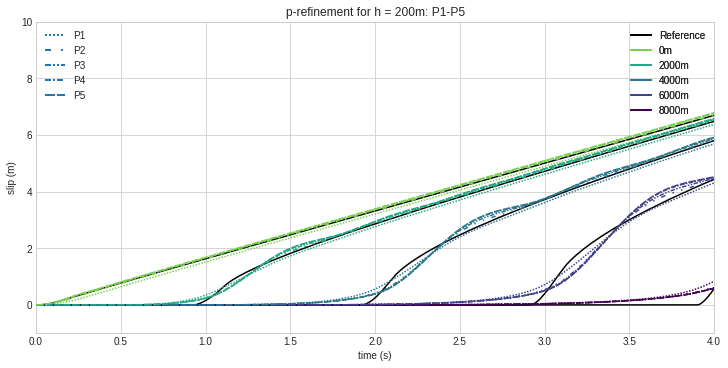

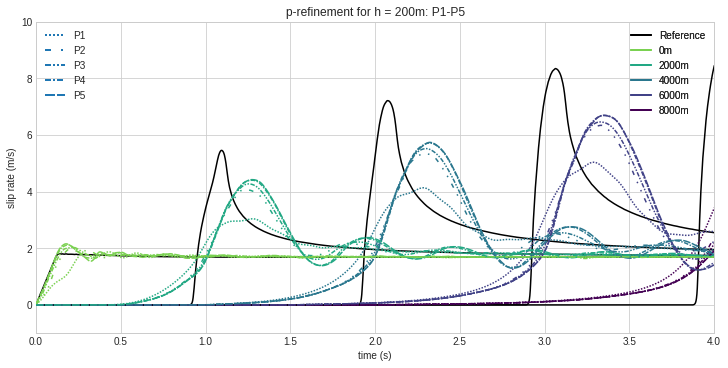

In [7]:
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200525/"
ListOfFolders = sorted(glob(path+"200*/*.pickle"))
[print(A) for A in ListOfFolders]
AllInOnePlot(ListOfFolders,"Slip","p-refinement for h = 200m: P1-P5")
AllInOnePlot(ListOfFolders,"SlipRate","p-refinement for h = 200m: P1-P5")

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200519/100dx-1p-100.01delta/TPList_t801_d100.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200519/100dx-2p-100.01delta/TPList_t801_d100.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200519/100dx-3p-100.01delta/TPList_t8000_d100.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200519/100dx-4p-100.01delta/TPList_t8000_d100.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200519/100dx-5p-100.01delta/TPList_t8000_d100.pickle


(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x152fe01437b8>)

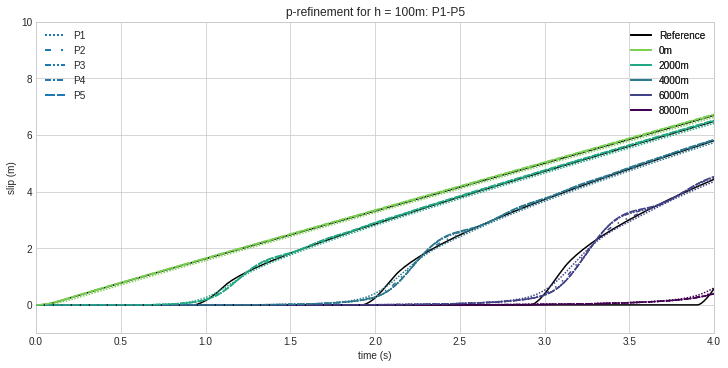

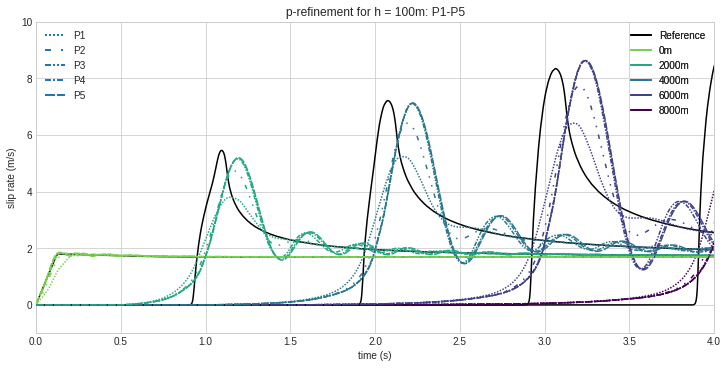

In [8]:
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200519/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))[:-1]
[print(A) for A in ListOfFolders]
AllInOnePlot(ListOfFolders,"Slip","p-refinement for h = 100m: P1-P5")
AllInOnePlot(ListOfFolders,"SlipRate","p-refinement for h = 100m: P1-P5")

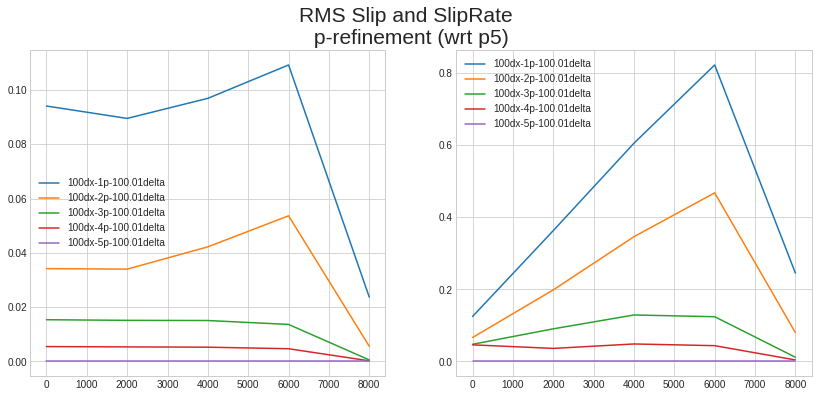

In [9]:
RMS_Plotting_fulltimeseries(ListOfFolders[-1],ListOfFolders)

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200525/050dx-1p-50.005delta/TPList_t4001_d50.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200525/050dx-2p-50.005delta/TPList_t4001_d50.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200525/050dx-3p-50.005delta/TPList_t4001_d50.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200525/050dx-4p-50.005delta/TPList_t8000_d50.pickle


(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x152feb2955c0>)

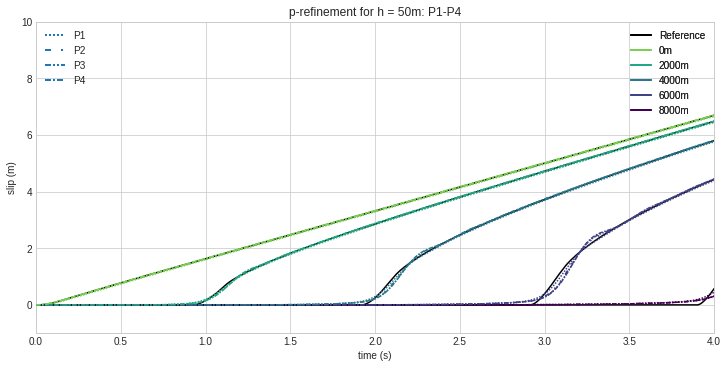

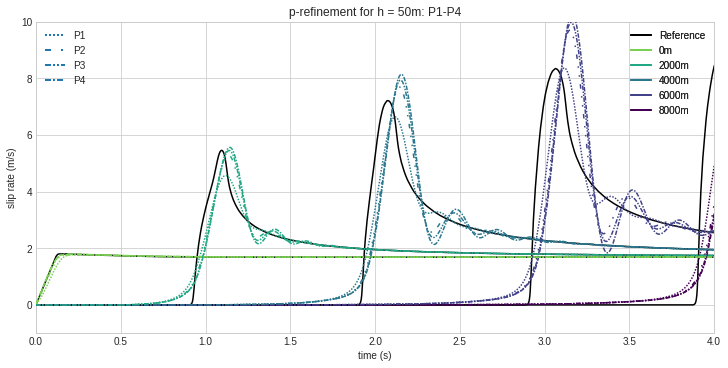

In [10]:
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200525/"
ListOfFolders = sorted(glob(path+"050*/*d50.pickle"))
[print(A) for A in ListOfFolders]
AllInOnePlot(ListOfFolders,"Slip","p-refinement for h = 50m: P1-P4")
AllInOnePlot(ListOfFolders,"SlipRate","p-refinement for h = 50m: P1-P4")

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200520/025dx-1p-25.003delta/TPList_t4001_d25.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200520/025dx-2p-25.003delta/TPList_t40000_d25.pickle


(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x152fdbbf85f8>)

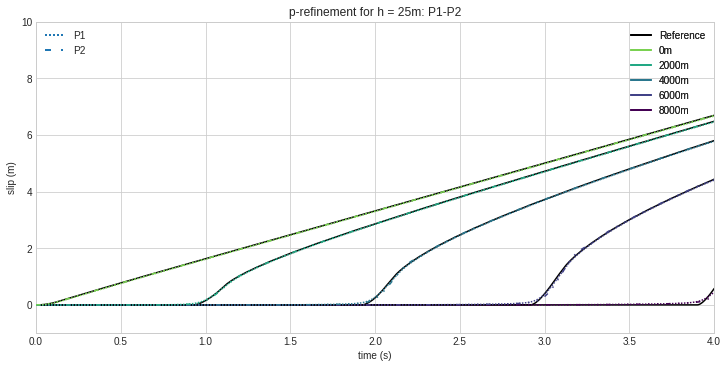

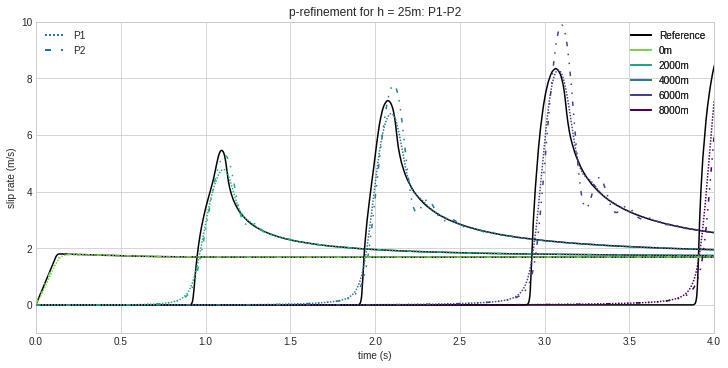

In [11]:
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200520/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
AllInOnePlot(ListOfFolders,"Slip","p-refinement for h = 25m: P1-P2")
AllInOnePlot(ListOfFolders,"SlipRate","p-refinement for h = 25m: P1-P2")

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/200dx-1p-100.01delta/TPList_t801_d100.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/200dx-2p-100.01delta/TPList_t801_d100.pickle


(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x152fdba16fd0>)

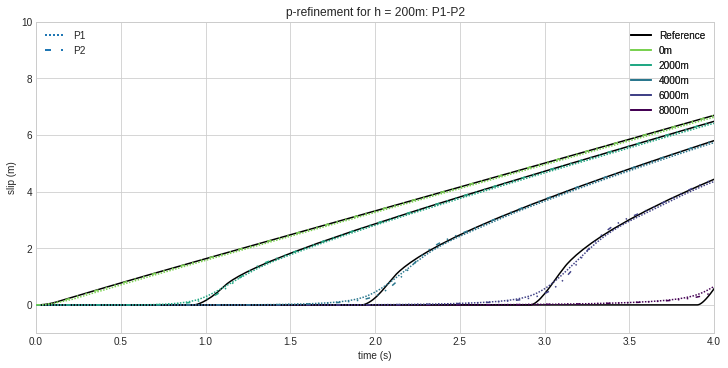

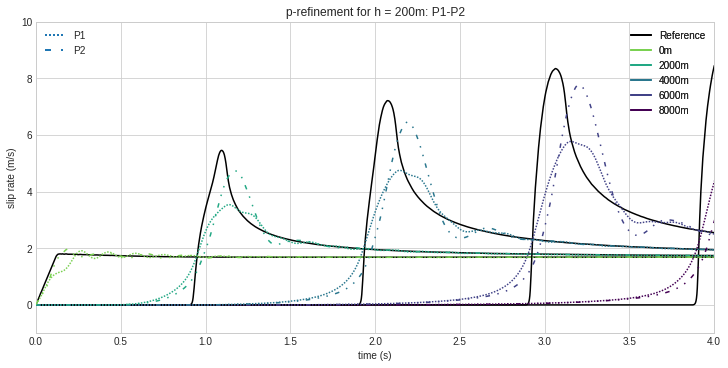

In [12]:
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/"
ListOfFolders = sorted(glob(path+"200*/*.pickle"))[:2]
[print(A) for A in ListOfFolders]
AllInOnePlot(ListOfFolders,"Slip","p-refinement for h = 200m: P1-P2")
AllInOnePlot(ListOfFolders,"SlipRate","p-refinement for h = 200m: P1-P2")

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/100dx-1p-50.005delta/TPList_t801_d50.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/100dx-2p-50.005delta/TPList_t8000_d50.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/100dx-3p-50.005delta/TPList_t4001_d50.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/100dx-4p-50.005delta/TPList_t8000_d50.pickle


(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x152fe041a080>)

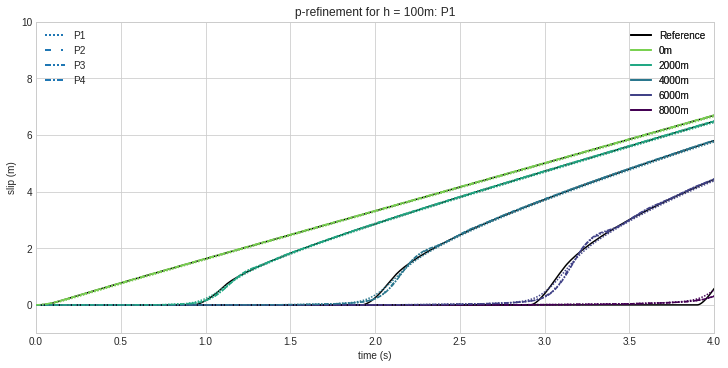

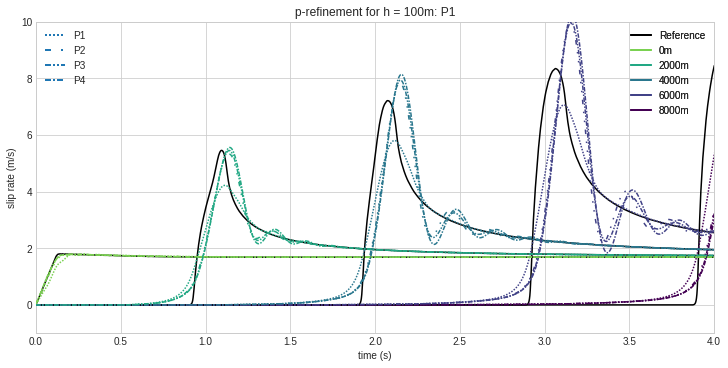

In [13]:
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/"
ListOfFolders = sorted(glob(path+"100*/*.pickle"))
[print(A) for A in ListOfFolders]
AllInOnePlot(ListOfFolders,"Slip","p-refinement for h = 100m: P1")
AllInOnePlot(ListOfFolders,"SlipRate","p-refinement for h = 100m: P1")

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200529/050dx-1p-100.01delta/TPList_t4001_d100.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200529/100dx-1p-100.01delta/TPList_t4001_d100.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200529/100dx-1p-50.005delta/TPList_t769_d50.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200529/200dx-1p-100.01delta/TPList_t385_d100.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200529/200dx-1p-50.010delta/TPList_t4001_d50.pickle


(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x152fdb9a5e10>)

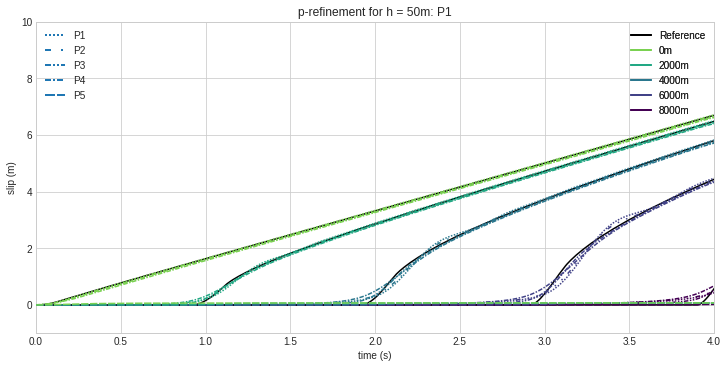

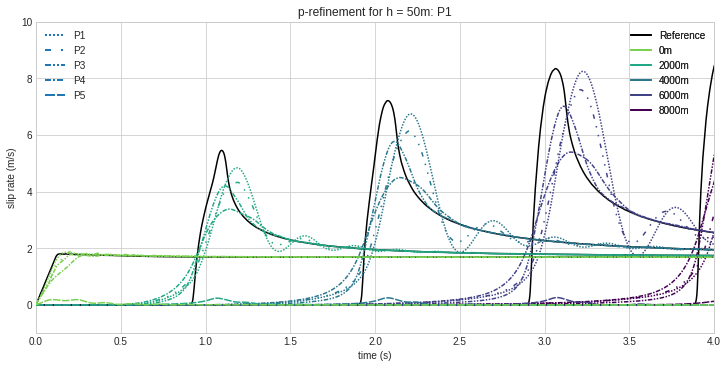

In [14]:
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200529/"
ListOfFolders = sorted(glob(path+"*1p*/*.pickle"))
[print(A) for A in ListOfFolders]
AllInOnePlot(ListOfFolders,"Slip","p-refinement for h = 50m: P1")
AllInOnePlot(ListOfFolders,"SlipRate","p-refinement for h = 50m: P1")

# h refinement w/ delta constant at 200m

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200525/025dx-1p-200.01delta/TPList_t4001_d200.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200525/050dx-1p-200.01delta/TPList_t4001_d200.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200525/100dx-1p-200.01delta/TPList_t801_d200.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200525/200dx-1p-200.02delta/TPList_t801_d200.pickle


(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x152fe04ac748>)

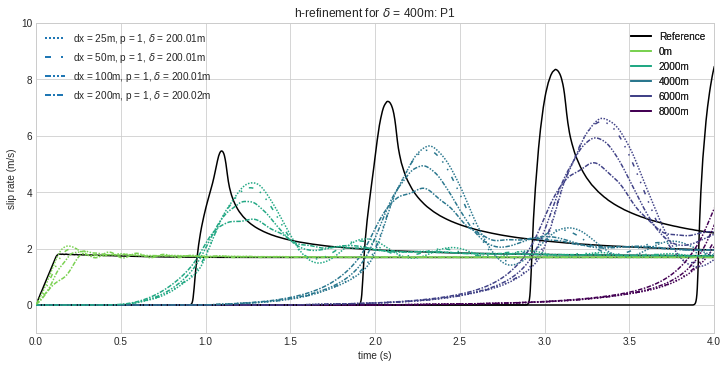

In [15]:
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200525/"
ListOfFolders = sorted(glob(path+"*1p*/*d200.pickle"))
[print(A) for A in ListOfFolders]
#AllInOnePlotDelta(ListOfFolders,"Slip","h-refinement for $\delta$ = 400m: P1")
AllInOnePlotDelta(ListOfFolders,"SlipRate","h-refinement for $\delta$ = 400m: P1")

# Filtered vs Non-filtered Slip rate of p-refinement simulations

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/050dx-1p-25.003delta/TPList_t4001_d25.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/050dx-2p-25.003delta/TPList_t8000_d25.003.pickle
----
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/100dx-1p-50.005delta/TPList_t801_d50.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/100dx-2p-50.005delta/TPList_t8000_d50.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/100dx-3p-50.005delta/TPList_t4001_d50.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/100dx-4p-50.005delta/TPList_t8000_d50.pickle
----
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/200dx-1p-100.01delta/TPList_t801_d100.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/200dx-2p-100.01delta/TPList_t801_d100.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/200dx-3p-100.01

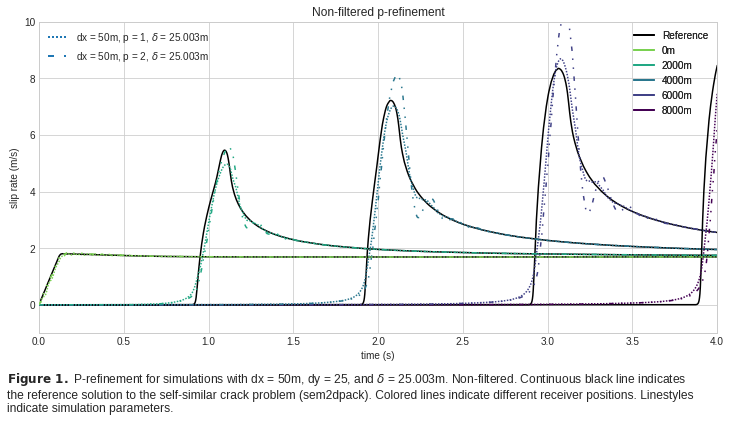

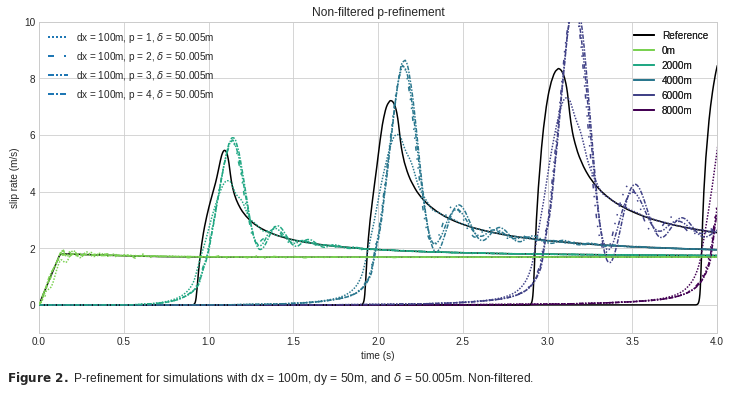

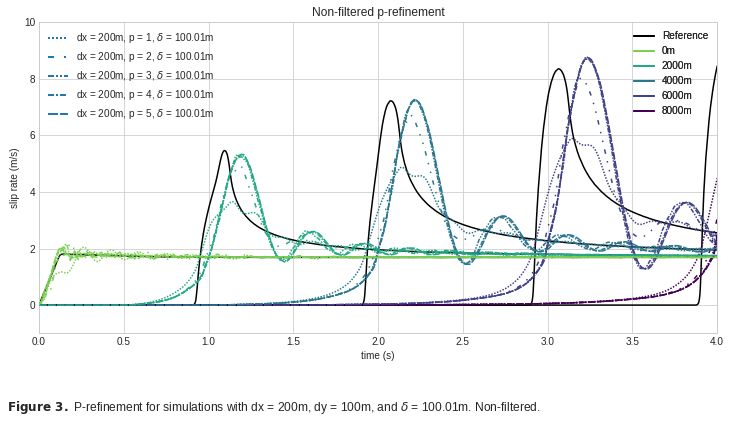

In [16]:
Caption1 =  "P-refinement for simulations with dx = 50m, dy = 25, and $\delta$ = 25.003m. "+\
            "Non-filtered. "+\
            "Continuous black line indicates \nthe reference solution to the self-similar crack problem (sem2dpack). "+\
            "Colored lines indicate different receiver positions. Linestyles \nindicate simulation parameters."

Caption2 =  "P-refinement for simulations with dx = 100m, dy = 50m, and $\delta$ = 50.005m. Non-filtered."
Caption3 =  "P-refinement for simulations with dx = 200m, dy = 100m, and $\delta$ = 100.01m. Non-filtered."

#-------------------------------------------------------------------
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/"
ListOfFolders = sorted(glob(path+"050*/*.pickle"))

[print(A) for A in ListOfFolders]


if ListOfFolders != []:
    AllInOnePlotDelta(ListOfFolders,"SlipRate","Non-filtered p-refinement",Filtered=False)
    plt.figtext(0., -0.13, r"$\bf{Figure\ 1.}$ " + Caption1, horizontalalignment='left', fontsize=12)
#--------------------------------------------------------------------
print("----")
ListOfFolders = sorted(glob(path+"100*/*.pickle"))

[print(A) for A in ListOfFolders]


if ListOfFolders != []:
    AllInOnePlotDelta(ListOfFolders,"SlipRate","Non-filtered p-refinement",Filtered=False)
    plt.figtext(0., -0.05, r"$\bf{Figure\ 2.}$ " + Caption2, horizontalalignment='left', fontsize=12)

#----------------------------------------------------------------------
print("----")
ListOfFolders = sorted(glob(path+"200*/*.pickle"))

[print(A) for A in ListOfFolders]

if ListOfFolders != []:
    AllInOnePlotDelta(ListOfFolders,"SlipRate","Non-filtered p-refinement",Filtered=False)
    plt.figtext(0., -0.13, r"$\bf{Figure\ 3.}$ " + Caption3, horizontalalignment='left', fontsize=12)

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/050dx-1p-25.003delta/TPList_t4001_d25.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/050dx-2p-25.003delta/TPList_t8000_d25.003.pickle
----
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/100dx-1p-50.005delta/TPList_t801_d50.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/100dx-2p-50.005delta/TPList_t8000_d50.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/100dx-3p-50.005delta/TPList_t4001_d50.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/100dx-4p-50.005delta/TPList_t8000_d50.pickle
----
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/200dx-1p-100.01delta/TPList_t801_d100.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/200dx-2p-100.01delta/TPList_t801_d100.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/200dx-3p-100.01

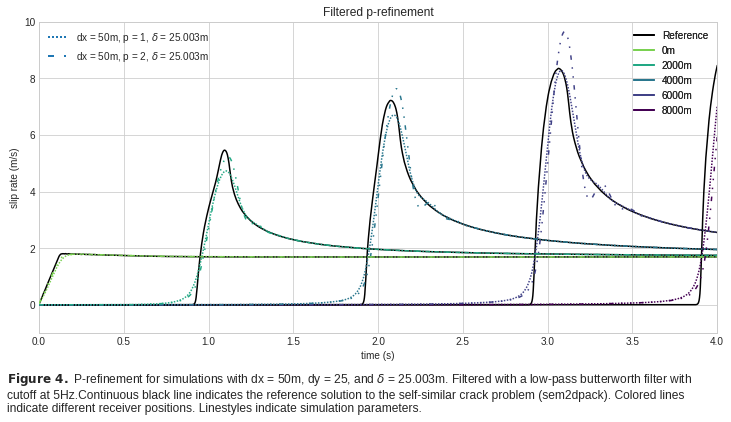

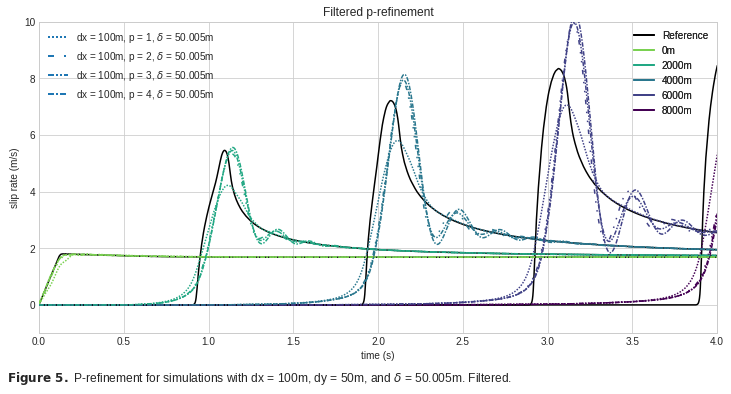

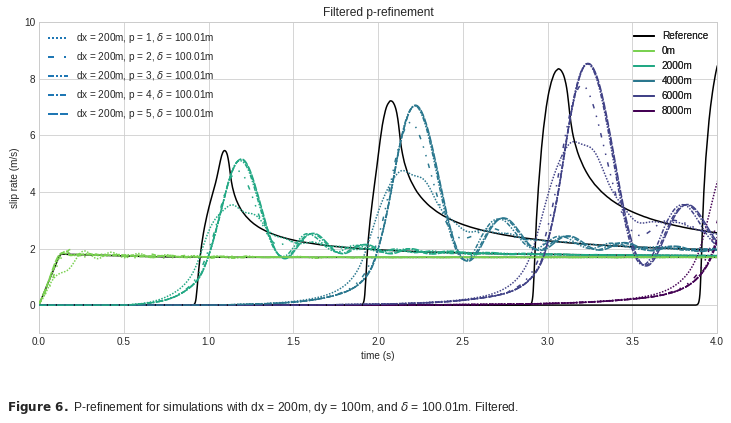

In [17]:
Caption1 =  "P-refinement for simulations with dx = 50m, dy = 25, and $\delta$ = 25.003m. "+\
            "Filtered with a low-pass butterworth filter with \ncutoff at 5Hz."+\
            "Continuous black line indicates the reference solution to the self-similar crack problem (sem2dpack). "+\
            "Colored lines \nindicate different receiver positions. Linestyles indicate simulation parameters."

Caption2 =  "P-refinement for simulations with dx = 100m, dy = 50m, and $\delta$ = 50.005m. Filtered."
Caption3 =  "P-refinement for simulations with dx = 200m, dy = 100m, and $\delta$ = 100.01m. Filtered."

#-----------------------------------------------------------------------------
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/"
ListOfFolders = sorted(glob(path+"050*/*.pickle"))

[print(A) for A in ListOfFolders]


if ListOfFolders != []:
    #AllInOnePlotDelta(ListOfFolders,"Slip","h- and $\delta$-refinement")
    AllInOnePlotDelta(ListOfFolders,"SlipRate","Filtered p-refinement")
    plt.figtext(0., -0.13, r"$\bf{Figure\ 4.}$ " + Caption1, horizontalalignment='left', fontsize=12)
#----------------------------------------------------------------------
print("----")
ListOfFolders = sorted(glob(path+"100*/*.pickle"))

[print(A) for A in ListOfFolders]


if ListOfFolders != []:
    #AllInOnePlotDelta(ListOfFolders,"Slip","h- and $\delta$-refinement")
    AllInOnePlotDelta(ListOfFolders,"SlipRate","Filtered p-refinement")
    plt.figtext(0., -0.05, r"$\bf{Figure\ 5.}$ " + Caption2, horizontalalignment='left', fontsize=12)
#-----------------------------------------------------------------------
print("----")
ListOfFolders = sorted(glob(path+"200*/*.pickle"))

[print(A) for A in ListOfFolders]

if ListOfFolders != []:
    #AllInOnePlotDelta(ListOfFolders,"Slip","h- and $\delta$-refinement")
    AllInOnePlotDelta(ListOfFolders,"SlipRate","Filtered p-refinement")
    plt.figtext(0., -0.13, r"$\bf{Figure\ 6.}$ " + Caption3, horizontalalignment='left', fontsize=12)

# Test with different weighthing for traction

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200612/200dx-3p-100.01delta/TPList_t8000_d100.01.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200612/200dx-3p-100.01deltaA/TPList_t4001_d100.01.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200612/200dx-3p-100.01deltaB/TPList_t4001_d100.01.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200612/200dx-3p-100.01deltaC/TPList_t4001_d100.01.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200612/200dx-3p-100.01deltaD/TPList_t4001_d100.01.pickle


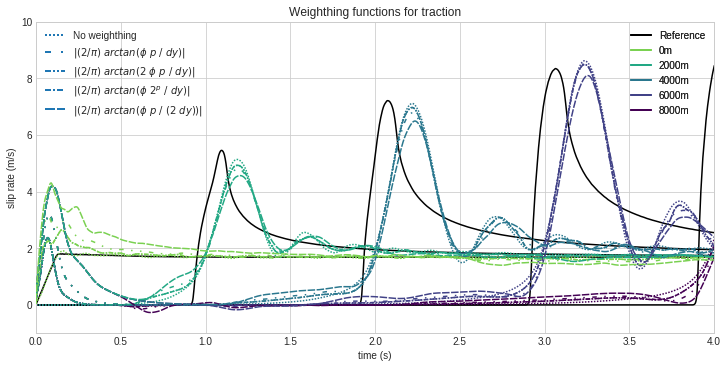

In [18]:
Caption1= "Simulations with parameters: dx = 200m, dy = 100m, p = 3, and delta = 100.01m. "+\
          "Filtered with a low-pass butterworth filter \n$f_c=5Hz$. "+\
          "Continuous black line indicates the reference solution to the self-similar crack problem (sem2dpack). "+\
          "Colored lines indicate \ndifferent receiver positions. Linestyles indicate different weighthing functions."



LegendNamesList=["No weighthing", 
                 r"$|(2/\pi)\ arctan({\phi\ p}\ /\ {dy})|$",
                 r"$|(2/\pi)\ arctan({2\ \phi\ p}\ /\ {dy})|$",
                 r"$|(2/\pi)\ arctan({\phi\ 2^p}\ /\ {dy})|$",
                 r"$|(2/\pi)\ arctan({\phi\ p}\ /\ {(2\ dy)})|$"]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200612/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Weighthing functions for traction",LegendNamesList)
    #plt.figtext(0., -0.13, r"$\bf{Figure\ 1.}$ " + Caption1, horizontalalignment='left', fontsize=12)


/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200612/200dx-3p-100.01delta/TPList_t8000_d100.01.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200612/200dx-3p-100.01deltaA/TPList_t4001_d100.01.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200612/200dx-3p-100.01deltaB/TPList_t4001_d100.01.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200612/200dx-3p-100.01deltaC/TPList_t4001_d100.01.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200612/200dx-3p-100.01deltaD/TPList_t4001_d100.01.pickle


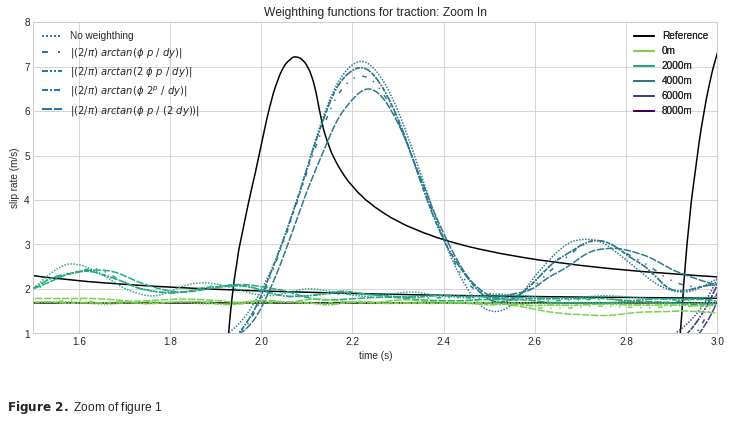

In [19]:
Caption1= "Zoom of figure 1 "
LegendNamesList=["No weighthing", 
                 r"$|(2/\pi)\ arctan({\phi\ p}\ /\ {dy})|$",
                 r"$|(2/\pi)\ arctan({2\ \phi\ p}\ /\ {dy})|$",
                 r"$|(2/\pi)\ arctan({\phi\ 2^p}\ /\ {dy})|$",
                 r"$|(2/\pi)\ arctan({\phi\ p}\ /\ {(2\ dy)})|$"]


path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200612/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Weighthing functions for traction: Zoom In",LegendNamesList)
    plt.xlim([1.5,3])
    plt.ylim([1,8])
    plt.figtext(0., -0.13, r"$\bf{Figure\ 2.}$ " + Caption1, horizontalalignment='left', fontsize=12)

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200619/100dx-3p-50.005deltaETA_A/TPList_t8000_d100.01.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200619/100dx-3p-50.005deltaETA_B/TPList_t4001_d50.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200619/100dx-3p-50.005deltaETA_C/TPList_t8000_d100.01.pickle


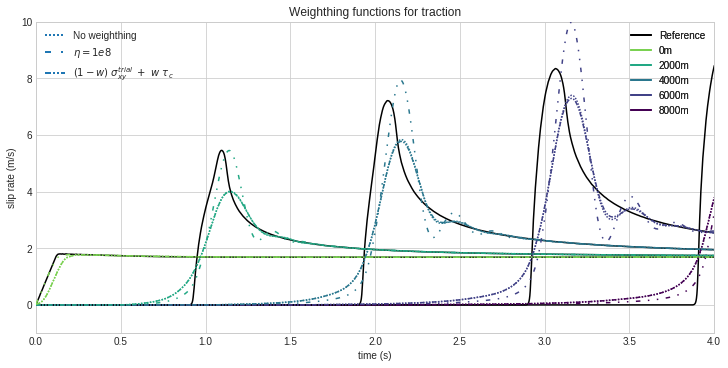

In [20]:
Caption1= "Simulations with parameters: dx = 400m, dy = 200m, p = 3, and delta = 200.02m. "+\
          "Filtered with a low-pass butterworth filter \n$f_c=5Hz$. "+\
          "Continuous black line indicates the reference solution to the self-similar crack problem (sem2dpack). "+\
          "Colored lines indicate \ndifferent receiver positions. Linestyles indicate different weighthing functions."



LegendNamesList=["No weighthing", 
                 r"$\eta = 1e8$",
                 r"$(1-w)\ \sigma^{trial}_{xy}\ +\ w\ \tau_c$"]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200619/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))[0:3]
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Weighthing functions for traction",LegendNamesList)
    #plt.figtext(0., -0.13, r"$\bf{Figure\ 1.}$ " + Caption1, horizontalalignment='left', fontsize=12)

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200622/100dx-3p-50.005deltaETA_A/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200622/100dx-3p-50.005deltaETA_B/TPList_t4001_d50.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200622/100dx-3p-50.005deltaETA_C/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200622/100dx-3p-50.005deltaETA_D/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200622/100dx-3p-50.005deltaETA_E/TPList_t8000_d50.005.pickle


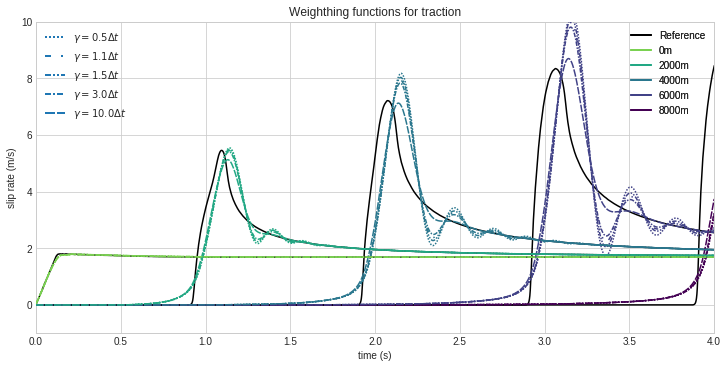

In [21]:
Caption1= "Simulations with parameters: dx = 400m, dy = 200m, p = 3, and delta = 200.02m. "+\
          "Filtered with a low-pass butterworth filter \n$f_c=5Hz$. "+\
          "Continuous black line indicates the reference solution to the self-similar crack problem (sem2dpack). "+\
          "Colored lines indicate \ndifferent receiver positions. Linestyles indicate different weighthing functions."



LegendNamesList=[r"$\gamma = 0.5\Delta t$", 
                 r"$\gamma = 1.1\Delta t$",
                 r"$\gamma = 1.5\Delta t$",
                 r"$\gamma = 3.0\Delta t$",
                 r"$\gamma = 10.0\Delta t$"]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200622/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Weighthing functions for traction",LegendNamesList)
    #plt.figtext(0., -0.13, r"$\bf{Figure\ 1.}$ " + Caption1, horizontalalignment='left', fontsize=12)

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200624/100dx-3p-50.005deltaNoW/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200624/100dx-3p-50.005deltaWPetscAfter/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200624/100dx-3p-50.005deltaWPetscTanh/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200624/100dx-3p-50.005deltaWSwitchedAfter/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200624/100dx-3p-50.005deltaWTanh/TPList_t8000_d50.005.pickle


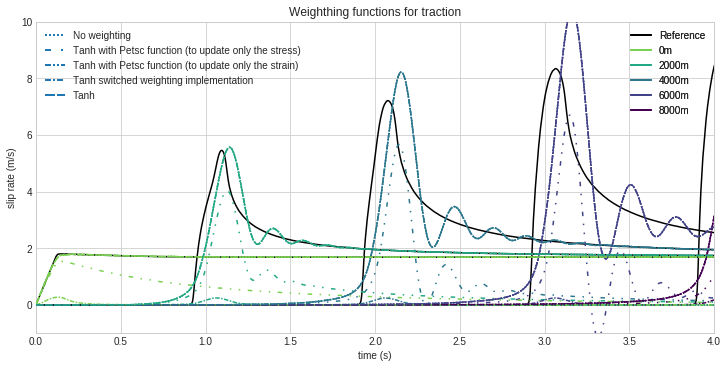

In [22]:
LegendNamesList=["No weighting", 
                 "Tanh with Petsc function (to update only the stress)",
                 "Tanh with Petsc function (to update only the strain)",
                 "Tanh switched weighting implementation",
                 "Tanh"]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200624/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Weighthing functions for traction",LegendNamesList)

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200625/100dx-3p-50.005deltaNoW/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200625/100dx-3p-50.005deltaWbeforeandafterETA_A/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200625/100dx-3p-50.005deltaWbnaAltW/TPList_t8000_d50.005.pickle


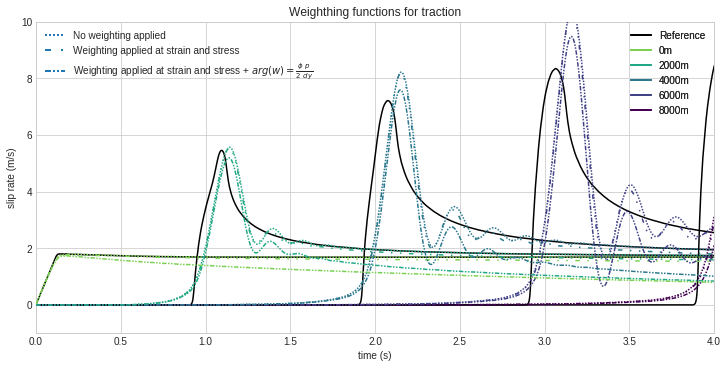

In [23]:
LegendNamesList=["No weighting applied", 
                 "Weighting applied at strain and stress",
                 r"Weighting applied at strain and stress + $arg(w)=\frac{\phi\ p}{2\ dy}$"]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200625/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Weighthing functions for traction",LegendNamesList)


/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200628/100dx-3p-50.005delta_TB/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200628/100dx-4p-50.005delta_TB/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200628/100dx-5p-50.005delta_TB/TPList_t8000_d50.005.pickle


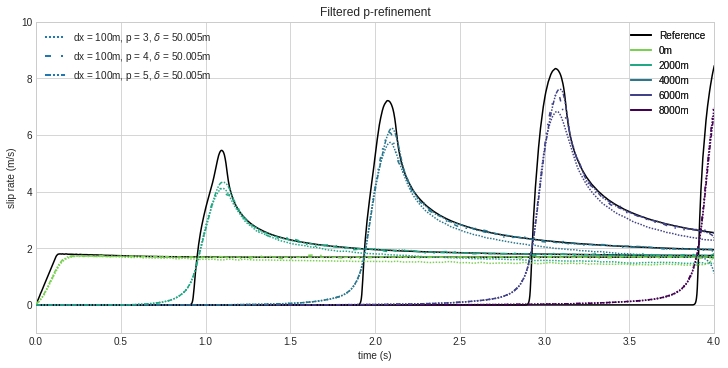

In [24]:
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200628/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))

[print(A) for A in ListOfFolders]

if ListOfFolders != []:
    #AllInOnePlotDelta(ListOfFolders,"Slip","h- and $\delta$-refinement")
    AllInOnePlotDelta(ListOfFolders,"SlipRate","Filtered p-refinement")


(-1, 10)

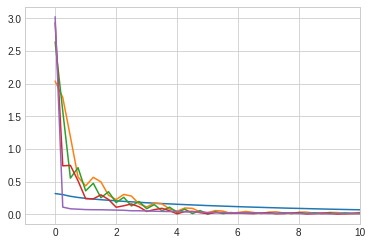

In [25]:

#for iidx,SingleFile in enumerate(ListOfFolders):
SingleFile = ListOfFolders[0]
head, tail = os.path.split(SingleFile)
File = LoadPickleFile(Filename = tail,FolderPath = head+"/")


for ffile in File:
    xf,yf = CalculateFFT(ffile.VelX)
    plt.plot(xf,yf)
plt.xlim([-1,10])


/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200629/100dx-3p-50.005delta_TB/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200629/100dx-3p-50.005delta_TC/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200629/100dx-3p-50.005delta_TD/TPList_t8000_d50.005.pickle


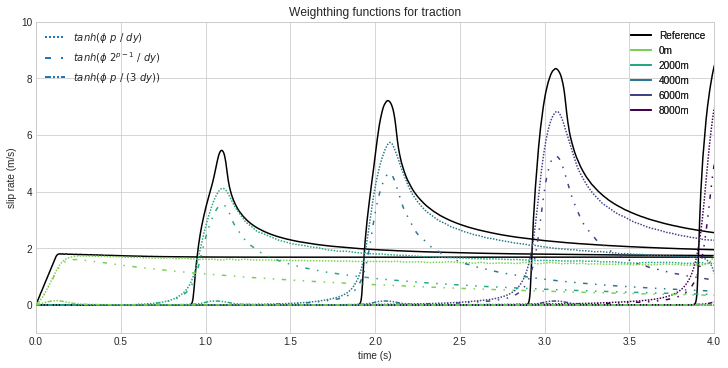

In [26]:
LegendNamesList=[r"$tanh({\phi\ p}\ /\ {dy})$",
                 r"$tanh({\phi\ 2^{p-1}}\ /\ {dy})$",
                 r"$tanh({\phi\ p}\ /\ {(3\ dy)})$"]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200629/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Weighthing functions for traction",LegendNamesList)

    

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200629Gamma/100dx-3p-50.005delta_TA/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200629Gamma/100dx-3p-50.005delta_TB/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200629Gamma/100dx-3p-50.005delta_TC/TPList_t8000_d50.005.pickle


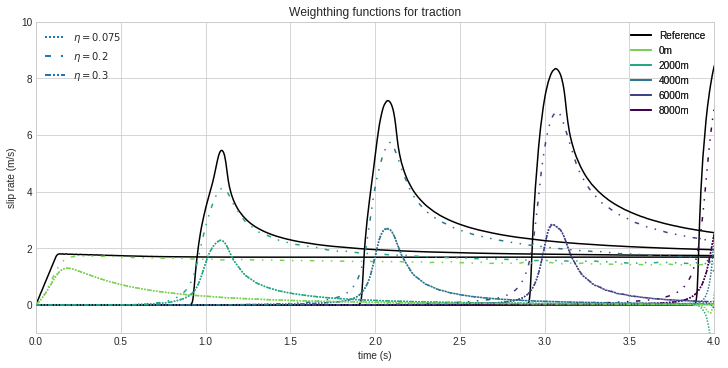

In [27]:
LegendNamesList=[r"$\eta = 0.075$",
                 r"$\eta = 0.2$",
                 r"$\eta = 0.3$"]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200629Gamma/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Weighthing functions for traction",LegendNamesList)

    

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200629MoreLoc/100dx-3p-50.005delta_Both/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200629MoreLoc/100dx-3p-50.005delta_OnlyStrain/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200629MoreLoc/100dx-3p-50.005delta_OnlyStress/TPList_t8000_d50.005.pickle


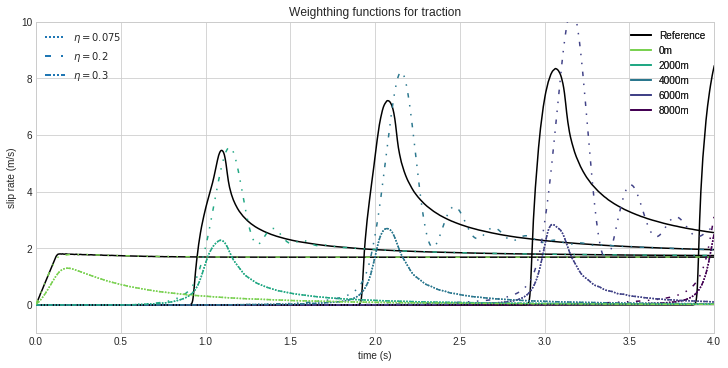

In [28]:
LegendNamesList=[r"$\eta = 0.075$",
                 r"$\eta = 0.2$",
                 r"$\eta = 0.3$"]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200629MoreLoc/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Weighthing functions for traction",LegendNamesList)

    

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200630/ViscosityTests/200dx-3p-100.01deltaETA_A/TPList_t4001_d100.01.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200630/ViscosityTests/200dx-3p-100.01deltaETA_B/TPList_t4001_d100.01.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200630/ViscosityTests/200dx-3p-100.01deltaETA_C/TPList_t4001_d100.01.pickle


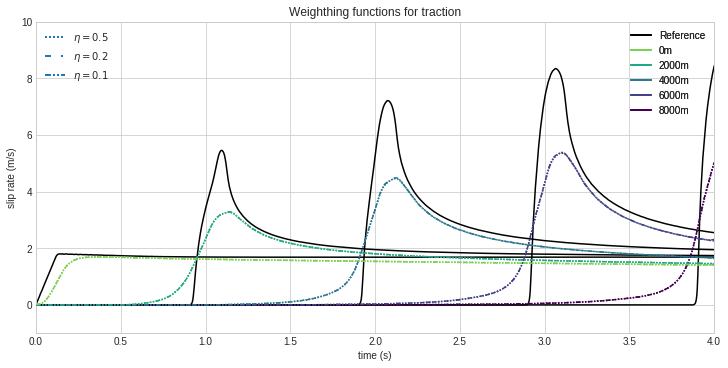

In [29]:
LegendNamesList=[r"$\eta = 0.5$",
                 r"$\eta = 0.2$",
                 r"$\eta = 0.1$",
                 r"$\eta = 0.075$"]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200630/ViscosityTests/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Weighthing functions for traction",LegendNamesList)


/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200630/Times/200dx-3p-100.01delta_D/TPList_t4001_d100.01.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200630/Times/200dx-3p-100.01delta_DD/TPList_t4001_d100.01.pickle


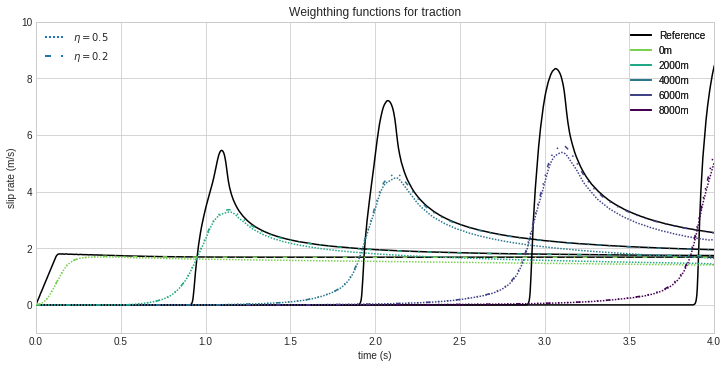

In [30]:
LegendNamesList=[r"$\eta = 0.5$",
                 r"$\eta = 0.2$",
                 r"$\eta = 0.1$",
                 r"$\eta = 0.075$"]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200630/Times/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Weighthing functions for traction",LegendNamesList)


/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200701/Paaan/100dx-4p-50.005delta_DD/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200701/Paaan/100dx-4p-50.005delta_DDD/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200701/Paaan/100dx-4p-50.005delta_WA/TPList_t8000_d50.005.pickle


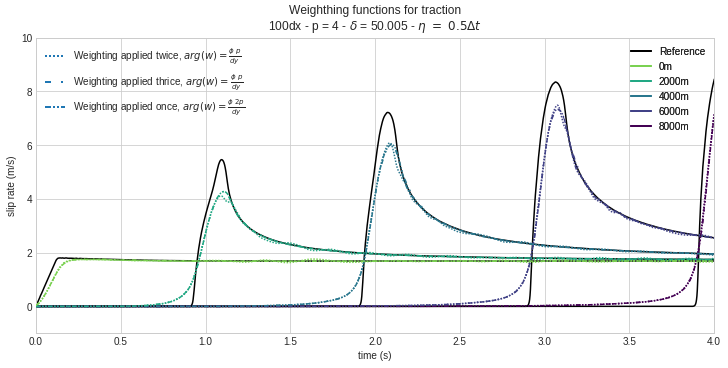

In [31]:
LegendNamesList=[r"Weighting applied twice, $arg(w)=\frac{\phi\ p}{dy}$",
                 r"Weighting applied thrice, $arg(w)=\frac{\phi\ p}{dy}$",
                 r"Weighting applied once, $arg(w)=\frac{\phi\ 2p}{dy}$"]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200701/Paaan/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Weighthing functions for traction\n100dx - p = 4 - $\delta$ = 50.005 - $\eta\ =\ 0.5\Delta t$",LegendNamesList)


/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200701/Paaan/100dx-4p-50.005delta_DD/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200701/Paaan/100dx-4p-50.005delta_DDD/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200701/Paaan/100dx-4p-50.005delta_WA/TPList_t8000_d50.005.pickle


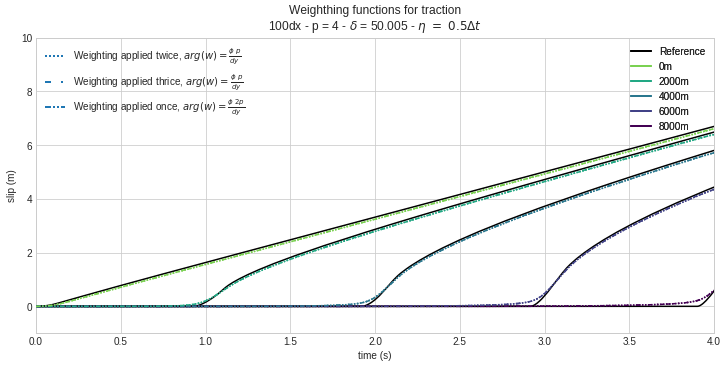

In [32]:
LegendNamesList=[r"Weighting applied twice, $arg(w)=\frac{\phi\ p}{dy}$",
                 r"Weighting applied thrice, $arg(w)=\frac{\phi\ p}{dy}$",
                 r"Weighting applied once, $arg(w)=\frac{\phi\ 2p}{dy}$"]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200701/Paaan/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"Slip","Weighthing functions for traction\n100dx - p = 4 - $\delta$ = 50.005 - $\eta\ =\ 0.5\Delta t$",LegendNamesList)


/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200703/100dx-4p-50.005delta_DD/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200703/100dx-4p-50.005delta_sigma/TPList_t8000_d50.005.pickle


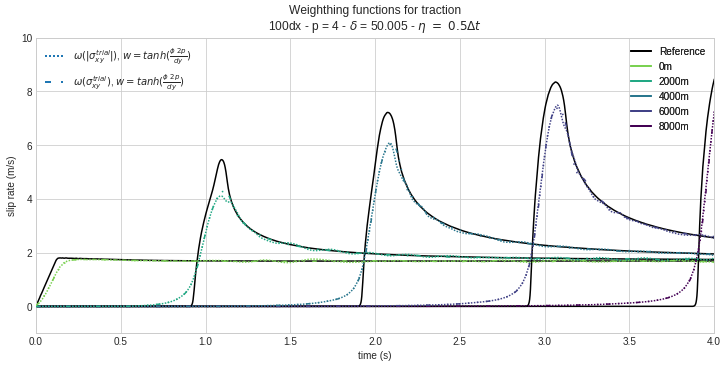

In [33]:
LegendNamesList=[r"$\omega(|\sigma_{xy}^{trial}|)$, $w=tanh(\frac{\phi\ 2p}{dy})$",
                 r"$\omega(\sigma_{xy}^{trial})$, $w=tanh(\frac{\phi\ 2p}{dy})$",
                 r"$\omega(\sigma_{xy}^{trial})$, $w^\pm=\frac{1}{2}tanh(\frac{\phi\ 2p}{dy}\pm1/2)\pm\ 1/2$",
                 r"$\omega(\sigma_{xy}^{trial})$, $w^\pm=|\frac{1}{2}tanh(\frac{\phi\ 2p}{dy}\pm1/2)\pm\ 1/2|$",
                ]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200703/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))[:2]
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Weighthing functions for traction\n100dx - p = 4 - $\delta$ = 50.005 - $\eta\ =\ 0.5\Delta t$",LegendNamesList)


/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200707/100dx-3p-50.005delta_Recenter/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200707/100dx-3p-50.005delta_RecenterAbs/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200707/100dx-3p-50.005delta_RecenteredArgThree/TPList_t8000_d50.005.pickle


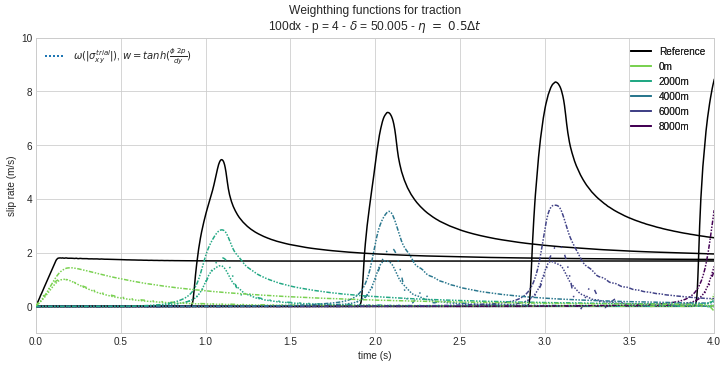

In [34]:
LegendNamesList=[r"$\omega(|\sigma_{xy}^{trial}|)$, $w=tanh(\frac{\phi\ 2p}{dy})$"
                ]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200707/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Weighthing functions for traction\n100dx - p = 4 - $\delta$ = 50.005 - $\eta\ =\ 0.5\Delta t$",LegendNamesList)


/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200713/100dx-3p-50.005delta_simpler/TPList_t8000_d50.005.pickle


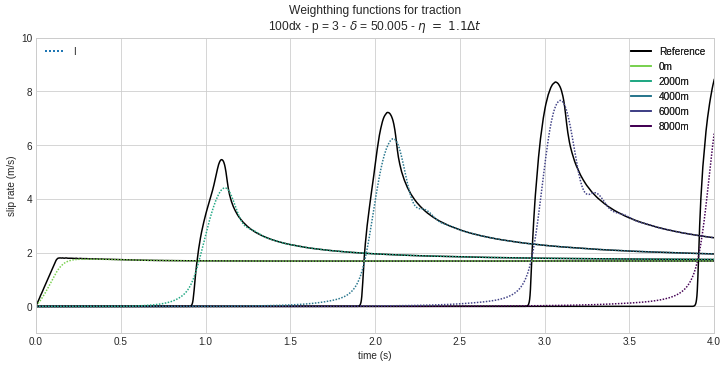

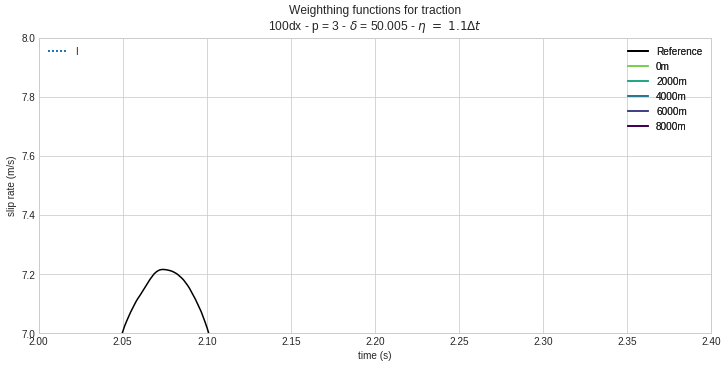

In [35]:
LegendNamesList=[r"I",
                 r"I",
                 r"I",
                 r"simple weighting",
                 r"I",
                ]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200713/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))[-1:]
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Weighthing functions for traction\n100dx - p = 3 - $\delta$ = 50.005 - $\eta\ =\ 1.1\Delta t$",LegendNamesList)
plt.show()
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Weighthing functions for traction\n100dx - p = 3 - $\delta$ = 50.005 - $\eta\ =\ 1.1\Delta t$",LegendNamesList)

plt.xlim([2,2.4])
plt.ylim([7,8])
plt.show()

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200714/100dx-3p-50.005delta_NoNegativity/TPList_t8000_d50.005.pickle


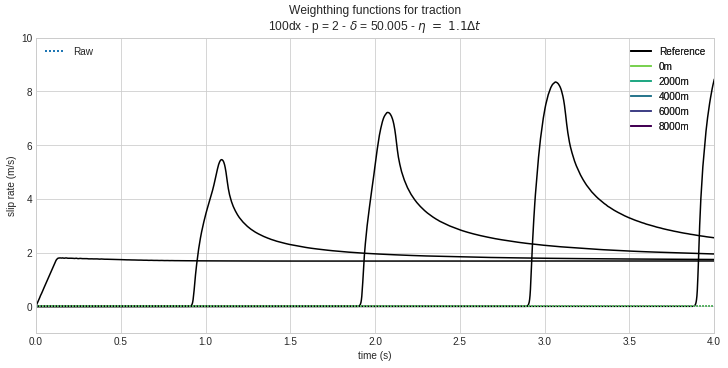

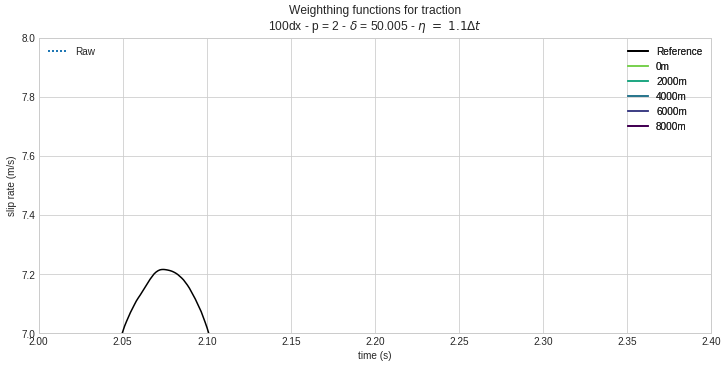

In [36]:
LegendNamesList=[r"Raw",
                 r"D",
                 r"E",
                 r"F",
                 r"G",
                ]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200714/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Weighthing functions for traction\n100dx - p = 2 - $\delta$ = 50.005 - $\eta\ =\ 1.1\Delta t$",LegendNamesList)
plt.show()
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Weighthing functions for traction\n100dx - p = 2 - $\delta$ = 50.005 - $\eta\ =\ 1.1\Delta t$",LegendNamesList)

plt.xlim([2,2.4])
plt.ylim([7,8])
plt.show()

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200716/100dx-2p-50.005delta_LeftLateral/TPList_t4001_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200716/100dx-2p-50.005delta_RightLateral/TPList_t4001_d50.005.pickle


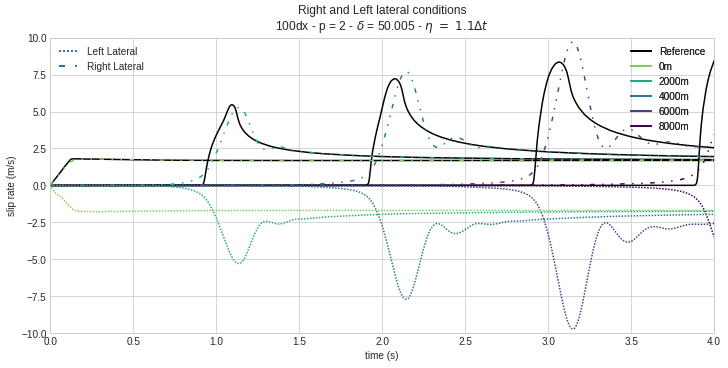

In [37]:
LegendNamesList=[r"Left Lateral",
                 r"Right Lateral"
                ]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200716/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Right and Left lateral conditions\n100dx - p = 2 - $\delta$ = 50.005 - $\eta\ =\ 1.1\Delta t$",LegendNamesList)


plt.ylim([-10,10])    
plt.show()


/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200716/100dx-2p-50.005delta_LeftLateral/TPList_t4001_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200716/100dx-2p-50.005delta_RightLateral/TPList_t4001_d50.005.pickle


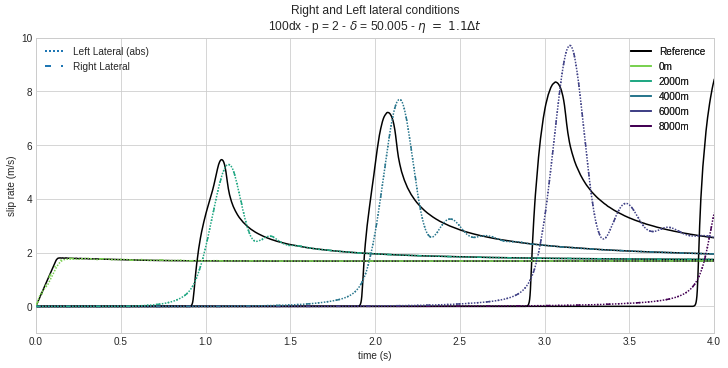

In [38]:
LegendNamesList=[r"Left Lateral (abs)",
                 r"Right Lateral"
                ]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200716/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegendAbs(ListOfFolders,"SlipRate","Right and Left lateral conditions\n100dx - p = 2 - $\delta$ = 50.005 - $\eta\ =\ 1.1\Delta t$",LegendNamesList)
   
plt.show()


/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200717/100dx-2p-50.005Test/TPList_t2420_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200717/100dx-2p-50.005delta_LeftSmooth/TPList_t4001_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200717/100dx-2p-50.005delta_LeftSymSmooth/TPList_t4001_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200717/100dx-2p-50.005delta_RightSmooth/TPList_t4001_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200717/100dx-2p-50.005delta_RightSymSmooth/TPList_t4001_d50.005.pickle


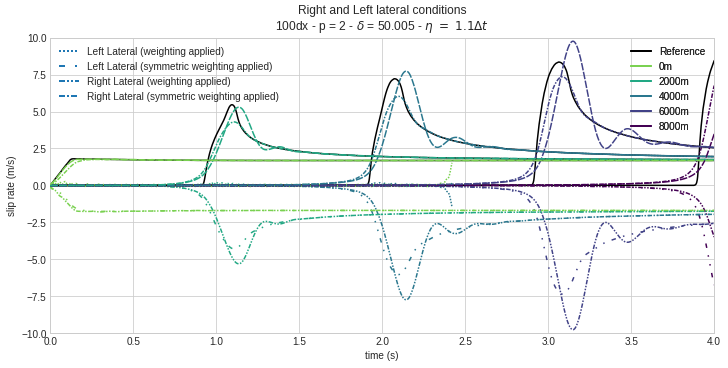

In [39]:
LegendNamesList=[r"Left Lateral (weighting applied)",
                 r"Left Lateral (symmetric weighting applied)",
                 r"Right Lateral (weighting applied)",
                 r"Right Lateral (symmetric weighting applied)",
                ]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200717/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegend(ListOfFolders,"SlipRate","Right and Left lateral conditions\n100dx - p = 2 - $\delta$ = 50.005 - $\eta\ =\ 1.1\Delta t$",LegendNamesList)


plt.ylim([-10,10])    
plt.show()


/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200718/100dx-3p-50.005delta_H/TPList_t8000_d50.005.pickle


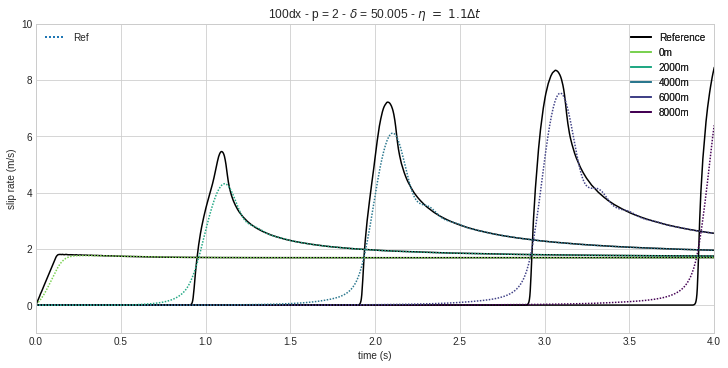

In [40]:
LegendNamesList=[r"Ref",
                 r"B",
                 r"C",
                ]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200718/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))[-1:]
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegendAbs(ListOfFolders,"SlipRate","100dx - p = 2 - $\delta$ = 50.005 - $\eta\ =\ 1.1\Delta t$",LegendNamesList)
   
plt.show()


/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200719/100dx-3p-50.005delta_A/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200719/100dx-4p-50.005delta_B/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200719/100dx-4p-50.005delta_C/TPList_t8000_d50.005.pickle


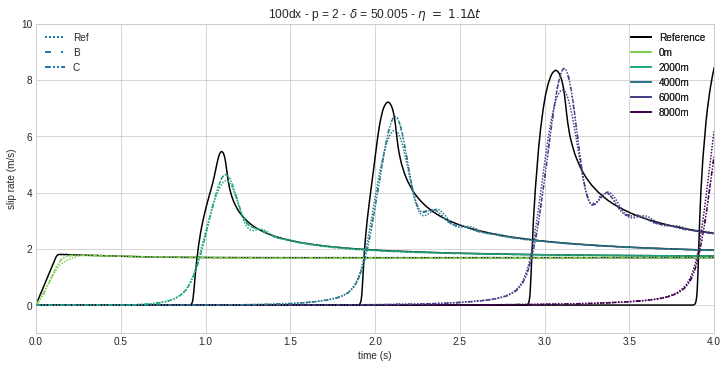

In [41]:
LegendNamesList=[r"Ref",
                 r"B",
                 r"C",
                ]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200719/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegendAbs(ListOfFolders,"SlipRate","100dx - p = 2 - $\delta$ = 50.005 - $\eta\ =\ 1.1\Delta t$",LegendNamesList)
   
plt.show()


/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200720/100dx-3p-50.005delta_F/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200720/100dx-4p-50.005delta_F/TPList_t8000_d50.005.pickle


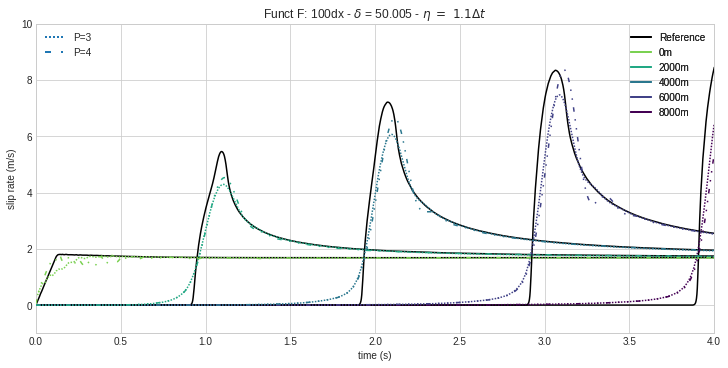

In [42]:
LegendNamesList=[r"P=3",
                 r"P=4",
                 r"P=4; X="
                ]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200720/"

ListOfFolders = sorted(glob(path+"*F/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegendAbs(ListOfFolders,"SlipRate","Funct F: 100dx - $\delta$ = 50.005 - $\eta\ =\ 1.1\Delta t$",LegendNamesList)
   
plt.show()


/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200720/100dx-3p-50.005delta_C/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200720/100dx-4p-50.005delta_C/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200720/100dx-4p-50.005delta_PerfC/TPList_t8000_d50.005.pickle


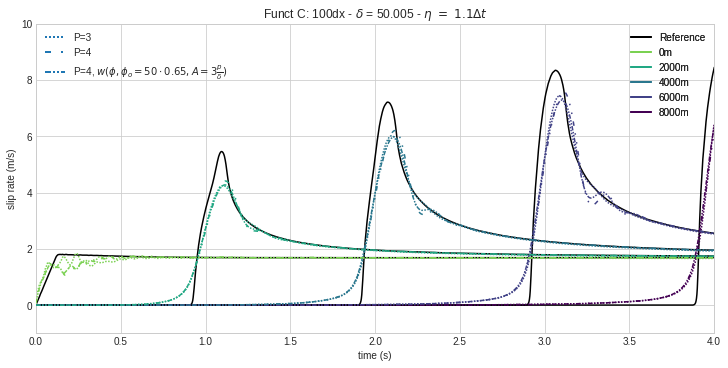

In [43]:
LegendNamesList=[r"P=3",
                 r"P=4",
                 r"P=4, $w(\phi,\phi_o=50 \cdot 0.65,A = 3\frac{p}{\delta})$",
                ]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200720/"
ListOfFolders = sorted(glob(path+"*C/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegendAbs(ListOfFolders,"SlipRate","Funct C: 100dx - $\delta$ = 50.005 - $\eta\ =\ 1.1\Delta t$",LegendNamesList)
   
plt.show()


/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200721/100dx-3p-50.005delta_B/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200721/100dx-3p-50.005delta_C/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200721/100dx-3p-50.005delta_D/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200721/100dx-3p-50.005delta_E/TPList_t8000_d50.005.pickle


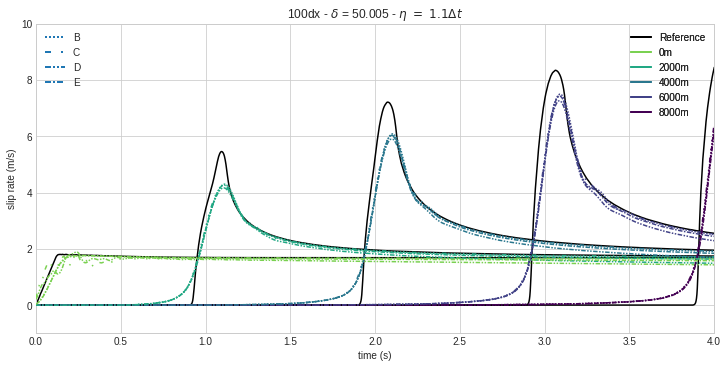

In [44]:
LegendNamesList=[r"B",
                 r"C",
                 r"D",
                 r"E"]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200721/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegendAbs(ListOfFolders,"SlipRate","100dx - $\delta$ = 50.005 - $\eta\ =\ 1.1\Delta t$",LegendNamesList)
   
plt.show()

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200723/100dx-3p-50.005delta_PreA/TPList_t8000_d50.005.pickle
/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200723/100dx-3p-50.005delta_PreB/TPList_t8000_d50.005.pickle


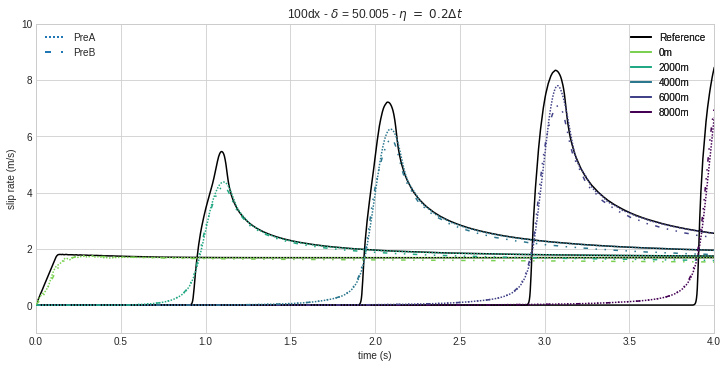

In [57]:
LegendNamesList=[r"PreA",r"PreB"]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200723/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegendAbs(ListOfFolders,"SlipRate","100dx - $\delta$ = 50.005 - $\eta\ =\ 0.2\Delta t$",LegendNamesList)
   
plt.show()

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200724/50dx-3p-25.003delta/TPList_t4001_d50.005.pickle


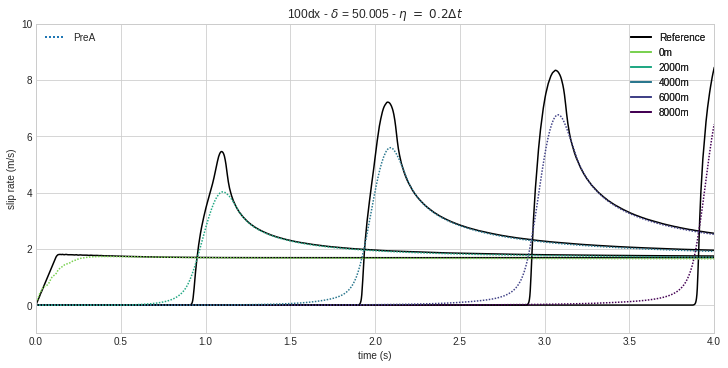

In [46]:
LegendNamesList=[r"PreA"]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200724/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegendAbs(ListOfFolders,"SlipRate","100dx - $\delta$ = 50.005 - $\eta\ =\ 0.2\Delta t$",LegendNamesList)
   
plt.show()

/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200726/50dx-4p-25.003delta/TPList_t40000_d25.003.pickle


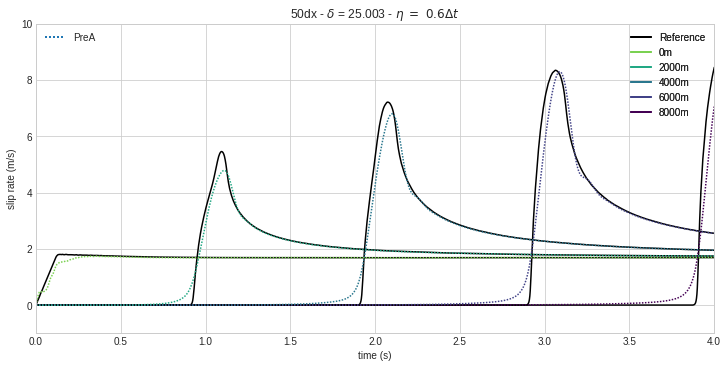

In [47]:
LegendNamesList=[r"PreA"]

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200726/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
[print(A) for A in ListOfFolders]
if ListOfFolders != []:
    PlotSpecificLegendAbs(ListOfFolders,"SlipRate","50dx - $\delta$ = 25.003 - $\eta\ =\ 0.6\Delta t$",LegendNamesList)
   
plt.show()

# Variables of Interest

In [49]:
VOI_Object = VOI_TimeProfile()

path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/20200527/"
ListOfFolders = sorted(glob(path+"*/*.pickle"))
Fill_VoiObject(ListOfFolders,VOI_Object)

pdVOI = VOI_Object.ConvertPOI2Pandas()

In [50]:
Ref = ReferenceStorage()
Refpath ="/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/Reference/"

for i in range(5):
    ListReference = sorted(glob(Refpath+"sem2dpack/sem2d-*{}.txt".format(i)))

    RefSlipData = []
    RefSRData = []
    RefTimeData = []
    
    for item in ListReference:
        if "sr" in item:
            line = pd.read_csv(item,header=None)
            RefTimeData, RefSRData = line[0], Butterworth(line[1])
        elif "slip" in item:
            line = pd.read_csv(item,header=None)
            RefTimeData, RefSlipData = line[0], Butterworth(line[1])


    Ref.StoreReference("sem2dpack", i*2000, RefSlipData, RefSRData, RefTimeData)

In [51]:
pdVOI

pref  href  deltaref   Loc     PeakSR  PeakSRtime    TailSR  TailSRtime  \
0      1    50    25.003  8000   7.460228       4.000  0.001031       2.130   
1      1    50    25.003  6000   8.687291       3.080  0.001009       1.590   
2      1    50    25.003  4000   7.016538       2.090  0.001074       1.060   
3      1    50    25.003  2000   4.967368       1.110  0.001014       0.525   
4      1    50    25.003     0   1.838272       0.165  0.030153       0.005   
5      2    50    25.003  8000   6.349396       4.000  0.001029       2.125   
6      2    50    25.003  6000  10.299012       3.105  0.001044       1.590   
7      2    50    25.003  4000   8.126064       2.110  0.001089       1.060   
8      2    50    25.003  2000   5.582667       1.120  0.001239       0.530   
9      2    50    25.003     0   1.844718       0.140  0.066390       0.005   
10     1   100    50.005  8000   5.694866       4.005  0.001039       2.070   
11     1   100    50.005  6000   7.313317       3.110  0.001000       1.540   
12     1   100    50.005  4000   6.018602       2.110  0.001012       1.015   
13     1   100    50.005  2000   4.387288       1.115  0.001004       0.490   
14     1   100    50.005     0   1.918880       0.205  0.016000       0.005   
15     2   100    50.005  8000   3.575939       4.000  0.001008       2.070   
16     2   100    50.005  6000  10.567413       3.160  0.001021       1.550   
17     2   100    50.005  4000   8.330292       2.155  0.001018       1.030   
18     2   100    50.005  2000   5.656504       1.150  0.001032       0.510   
19     2   100    50.005     0   1.858298       0.305  0.043668       0.005   
20     3   100    50.005  8000   3.431450       4.000  0.001029       2.070   
21     3   100    50.005  6000  10.535450       3.155  0.001043       1.550   
22     3   100    50.005  4000   8.456055       2.145  0.001072       1.030   
23     3   100    50.005  2000   5.825173       1.140  0.001130       0.510   
24     3   100    50.005     0   1.936702       0.145  0.065380       0.005   
25     4   100    50.005  8000   3.213638       4.000  0.001020       2.070   
26     4   100    50.005  6000  10.844030       3.160  0.001026       1.550   
27     4   100    50.005  4000   8.642043       2.160  0.001028       1.030   
28     4   100    50.005  2000   5.904927       1.140  0.001044       0.510   
29     4   100    50.005     0   1.918771       0.135  0.065483       0.005   
30     1   200   100.010  8000   4.593292       4.005  0.001008       2.000   
31     1   200   100.010  6000   5.884811       3.145  0.001060       1.480   
32     1   200   100.010  4000   4.870157       2.140  0.001008       0.955   
33     1   200   100.010  2000   3.656028       1.140  0.001073       0.440   
34     1   200   100.010     0   2.047412       0.265  0.008000       0.005   
35     2   200   100.010  8000   3.190076       4.005  0.001068       2.015   
36     2   200   100.010  6000   8.020764       3.200  0.001036       1.500   
37     2   200   100.010  4000   6.695596       2.195  0.001115       0.990   
38     2   200   100.010  2000   4.914901       1.185  0.001223       0.480   
39     2   200   100.010     0   2.190626       0.190  0.024000       0.005   
40     3   200   100.010  8000   2.514008       4.000  0.001070       2.030   
41     3   200   100.010  6000   8.774697       3.230  0.001180       1.520   
42     3   200   100.010  4000   7.253752       2.220  0.001072       1.005   
43     3   200   100.010  2000   5.292808       1.165  0.001220       0.495   
44     3   200   100.010     0   2.162446       0.160  0.043563       0.005   
45     4   200   100.010  8000   2.432171       4.000  0.001055       2.030   
46     4   200   100.010  6000   8.737199       3.240  0.001173       1.520   
47     4   200   100.010  4000   7.208676       2.220  0.001064       1.005   
48     4   200   100.010  2000   5.327631       1.195  0.001061       0.495   
49     4   200   100.010     0   2.072866       0.145 

In [52]:
def PlotTwoListsAndAnnotate(ax, List1, List2, List3, **kwargs):
    ax.plot(List1, List2, **kwargs)
    for i, txt in enumerate(List3):
        ax.annotate(str(txt), (List1[i], List2[i]))

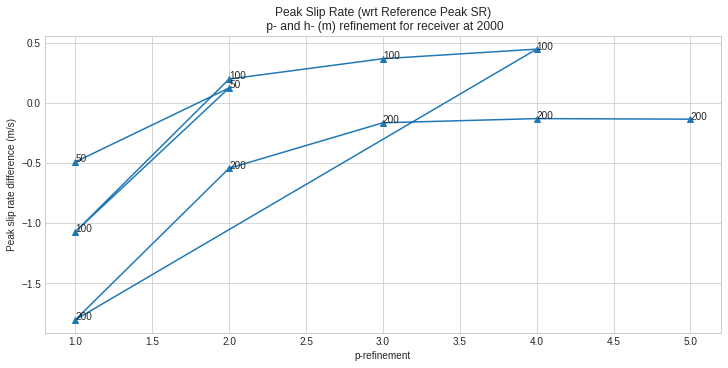

In [53]:
try:
    fig = plt.figure(figsize = (10,5), constrained_layout=True)
    gs = fig.add_gridspec(1, 1)
    ax = fig.add_subplot(gs[:, :])
except:
    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(1,1,1)

ax.set_xlabel("p-refinement")
ax.set_ylabel("Peak slip rate difference (m/s)")
ax.set_title("Peak Slip Rate (wrt Reference Peak SR)\n p- and h- (m) refinement for receiver at 2000")

LocIdx = 1

pLoc = pdVOI[ pdVOI.Loc.isin([LocIdx * 2000])]

PeakRefDiff = list(np.asarray(pLoc["PeakSR"].tolist()) - Ref.PeakSR[LocIdx])
href = pLoc["href"].tolist()
pref = list(np.asarray(pLoc["pref"].tolist()))

param={"marker": "^"}
PlotTwoListsAndAnnotate(ax, pref, PeakRefDiff, href,**param)

In [54]:
pLoc

pref  href  deltaref   Loc    PeakSR  PeakSRtime    TailSR  TailSRtime  \
3      1    50    25.003  2000  4.967368       1.110  0.001014       0.525   
8      2    50    25.003  2000  5.582667       1.120  0.001239       0.530   
13     1   100    50.005  2000  4.387288       1.115  0.001004       0.490   
18     2   100    50.005  2000  5.656504       1.150  0.001032       0.510   
23     3   100    50.005  2000  5.825173       1.140  0.001130       0.510   
28     4   100    50.005  2000  5.904927       1.140  0.001044       0.510   
33     1   200   100.010  2000  3.656028       1.140  0.001073       0.440   
38     2   200   100.010  2000  4.914901       1.185  0.001223       0.480   
43     3   200   100.010  2000  5.292808       1.165  0.001220       0.495   
48     4   200   100.010  2000  5.327631       1.195  0.001061       0.495   
53     5   200   100.010  2000  5.322955       1.205  0.001009       0.495   

    PTSRdiff  PTSRtimediff  
3   4.966354         0.585  
8   5.581428         0.590  
13  4.386284         0.625  
18  5.655472         0.640  
23  5.824043         0.630  
28  5.903883         0.630  
33  3.654955         0.700  
38  4.913678         0.705  
43  5.291588         0.670  
48  5.326570         0.700  
53  5.321946         0.710

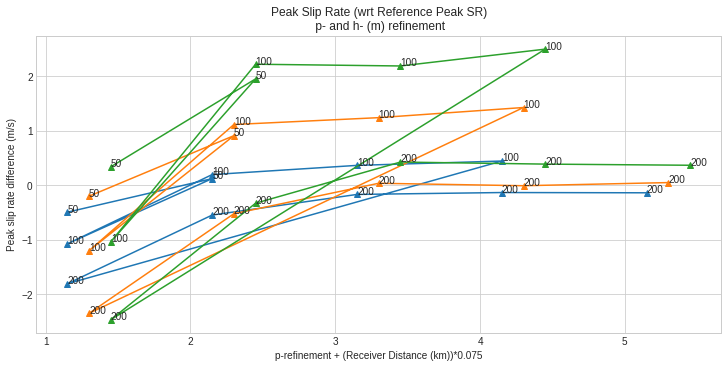

In [55]:
try:
    fig = plt.figure(figsize = (10,5), constrained_layout=True)
    gs = fig.add_gridspec(1, 1)
    ax = fig.add_subplot(gs[:, :])
except:
    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(1,1,1)

ax.set_xlabel("p-refinement + (Receiver Distance (km))*0.075")
ax.set_ylabel("Peak slip rate difference (m/s)")
ax.set_title("Peak Slip Rate (wrt Reference Peak SR)\n p- and h- (m) refinement")

for LocIdx in range(1,4):

    pLoc = pdVOI[ pdVOI.Loc.isin([LocIdx * 2000])]

    PeakRefDiff = list(np.asarray(pLoc["PeakSR"].tolist()) - Ref.PeakSR[LocIdx])
    href = pLoc["href"].tolist()
    pref = list(np.asarray(pLoc["pref"].tolist())+LocIdx*0.15)




    param={"marker": "^"}
    PlotTwoListsAndAnnotate(ax, pref, PeakRefDiff, href,**param)


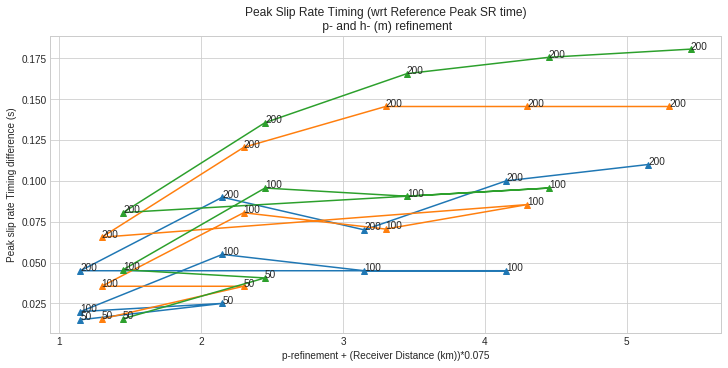

In [56]:
try:
    fig = plt.figure(figsize = (10,5), constrained_layout=True)
    gs = fig.add_gridspec(1, 1)
    ax = fig.add_subplot(gs[:, :])
except:
    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(1,1,1)

ax.set_xlabel("p-refinement + (Receiver Distance (km))*0.075")
ax.set_ylabel("Peak slip rate Timing difference (s)")
ax.set_title("Peak Slip Rate Timing (wrt Reference Peak SR time)\n p- and h- (m) refinement")

for LocIdx in range(1,4):

    pLoc = pdVOI[ pdVOI.Loc.isin([LocIdx * 2000])]

    PeakRefDiff = list(np.asarray(pLoc["PeakSRtime"].tolist()) - Ref.PeakSRTime[LocIdx])
    href = pLoc["href"].tolist()
    pref = list(np.asarray(pLoc["pref"].tolist())+LocIdx*0.15)




    param={"marker": "^"}
    PlotTwoListsAndAnnotate(ax, pref, PeakRefDiff, href,**param)